In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from IPython.display import Audio
import librosa

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report


$precision = \frac{TP}{TP \ + \ FP}$

$recall = \frac{TP}{TP \ + \ FN}$

$F_{1} = \frac{2 \ \times \ precision \ \times \ recall}{precision \ + \ recall}$

In [3]:
data_dir = '/Users/yingli/Development/TopicsInDataScience/voice_clip_selected/'
voice_feature = pd.read_csv(data_dir+"voice_feature_20241022.csv")

In [4]:
col_list_mfcc = ['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23',
       'mfcc_24']
col_list_f0 = ['f0_mean', 'f0_std','f0_var','f0_min','f0_max','f0_skew', 'f0_kurtosis']
col_list_zcr = ['zcr_mean','zcr_std','zcr_var','zcr_min','zcr_max','zcr_skew','zcr_kurtosis']

In [5]:
age_name = ['teens', 'twenties','thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties','nineties']
age_value = range(1,10)
age_dict = dict(zip(age_name, age_value))
gender_name = ["male_masculine","female_feminine"]
gender_value = [0,1]
gender_dict = dict(zip(gender_name, gender_value))
voice_feature['age'] = voice_feature['age'].map(age_dict)
voice_feature['gender'] = voice_feature['gender'].map(gender_dict)
voice_feature.dropna(inplace=True)

There are 16 clips with NA's in f0, for which we could impute the NA's by "mean" or more suitable imputation strategies. However, we knew f0 features are very important for voice analytics, imputing f0 related features may not be best for building voice models. Hence, we just drop those rows in our model building. Thus trained ML models may not handle NA in prediction, whereas in real life, we need to make our models accept NA input and not fail or exit gracefully.

## Build a speaker recognizer by classification

we will build a classifier for a speaker who has more clips in our selection (so that we can have more training data)

* client_id: '81516963704c4bbecc85d974b769a0ed4871707afd30d387fb5e4de72f9bfe97b9e5f3b3e3277d1ac2e51156907a781030de02a2eb45fa52c30e825aa1d1ebcb'
  * demo: seventies,male_masculine, Scottish English 
  * the speaker does have somewhat distinct voice but still the class imbalance is too strong


* client_id: '27c2bcb5074395819c7360c4a8711977e6258352ab80dc99bd9708f9eda0de82064daa9dad6a28ac8e543c3d6702adc2c7ad9f4ff7b4e86d399955f3b7021318'
  *  demo: thirties, male_masculine, United States English
  * We will use this one to build a speaker recognizer


* client_id: 'a33afddc9bfab2d5710efcb0a162d6e8e2ed092be3a59e2e2d4a04989829a5719b5214ed0071a65d8c597122232ff21706fdbd7ee855fb529d1cc9cba1b85d1f'
  * demo: thirties, male_masculine, United States English

In [6]:
voice_feature.groupby("client_id")[["path"]].count().sort_values(by="path", ascending=False).head(5)

,path
client_id,
81516963704c4bbecc85d974b769a0ed4871707afd30d387fb5e4de72f9bfe97b9e5f3b3e3277d1ac2e51156907a781030de02a2eb45fa52c30e825aa1d1ebcb,167
27c2bcb5074395819c7360c4a8711977e6258352ab80dc99bd9708f9eda0de82064daa9dad6a28ac8e543c3d6702adc2c7ad9f4ff7b4e86d399955f3b7021318,136
a33afddc9bfab2d5710efcb0a162d6e8e2ed092be3a59e2e2d4a04989829a5719b5214ed0071a65d8c597122232ff21706fdbd7ee855fb529d1cc9cba1b85d1f,128
b398dbe61e96ad337be48fb6c492f59722416ddc8a4e49ebcb554c24fc41eeaab6712720e243fc8a1fd792eee7266cefb0503fad3bf3261bcb593a583425106d,110
3f8c120d55b1e8fd45b4588a8e981e61040eda6923828a5f483f704ba201e745359478b3ea8d80b5c0d1798ba948d7de3a80d65f5e1a7f53ebf1a8143ab0d0eb,104


In [7]:
speaker_selected = '27c2bcb5074395819c7360c4a8711977e6258352ab80dc99bd9708f9eda0de82064daa9dad6a28ac8e543c3d6702adc2c7ad9f4ff7b4e86d399955f3b7021318'
voice_feature.query("client_id == @speaker_selected").head(1)

,f0_mean,f0_std,f0_var,f0_min,f0_max,f0_skew,f0_kurtosis,zcr_mean,zcr_std,zcr_var,...,sentence_id,sentence,up_votes,down_votes,age,gender,accents,len_in_second,sampling_rate,array_size
16099,99.409738,20.129965,405.215471,55.478474,128.194408,-0.963852,-0.063576,0.070033,0.07244,0.005248,...,dcc99eae8541d133aa05d09413149e5ce67a9f44917600...,He threw more pitches per inning than any star...,2,0,3,0,United States English,4.14,32000,132480


In [8]:
temp_clip = voice_feature.query("client_id == @speaker_selected")["path"].tolist()[0]
x, sr = librosa.load(data_dir+temp_clip,sr=None) 
#common_voice_en_33402102.mp3
Audio(data=x, rate=sr)

Adding a target column to our feature table, let's call it "speaker"

In [9]:
voice_feature['speaker'] = 1 * (voice_feature["client_id"] == speaker_selected)

In [10]:
voice_feature.speaker.value_counts()[1]/voice_feature.speaker.value_counts()[0]

0.010292114424095656

In [11]:
voice_feature.groupby("speaker").nunique().client_id[1]/voice_feature.groupby("speaker").nunique().client_id[0]

0.0011074197120708748

* this speaker accounts for 1% of the total speakers, and 0.11% or the clips.
* we need to down sample the rest of the speakers or clips

In [12]:
df1 = voice_feature.query("speaker == 1").copy().reset_index()
df2 = voice_feature.query("speaker == 0").copy().reset_index()
df2 = df2.sample(n=167*5, weights='age', replace=False, random_state=7)
voice_feature_speaker = pd.concat([df2,df1],axis=0)
voice_feature_speaker.shape

(971, 53)

In [13]:
X = voice_feature_speaker[col_list_f0 + col_list_mfcc + col_list_zcr]
#X = voice_feature_speaker[col_list_f0 + col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_feature_speaker.speaker
X_feature_name = scaler.feature_names_in_

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)

In [14]:
tree_clf = DecisionTreeClassifier(criterion= "entropy", random_state=7,max_depth=4).fit(X_train, y_train)
mlp_clf = MLPClassifier(random_state=7, max_iter=1000, hidden_layer_sizes=(500)).fit(X_train, y_train)
nb_clf = MultinomialNB().fit(X_train,y_train)
rf_clf = RandomForestClassifier(random_state=7).fit(X_train, y_train)
lg_clf = LogisticRegression(max_iter=300,random_state=7).fit(X_train, y_train)
svm_clf = svm.LinearSVC().fit(X_train, y_train)

In [18]:
metrics.confusion_matrix(y_test, svm_clf.predict(X_test))

array([[269,   1],
       [  3,  48]])

In [16]:
thresh = 0.5
model = rf_clf
y_pred = model.predict(X_test)
y_pred_thresh = np.array((model.predict_proba(X_test)[:, 1] > thresh).astype(int))
confusion_matrix(y_test,y_pred), confusion_matrix(y_test,y_pred_thresh)

(array([[270,   0],
        [ 10,  41]]),
 array([[270,   0],
        [ 10,  41]]))

In [44]:
y_test.value_counts(0)

speaker
0    270
1     51
Name: count, dtype: int64

In [45]:
thresh = 0.3
y_pred_thresh = np.array((model.predict_proba(X_test)[:, 1] > thresh).astype(int))
confusion_matrix(y_test,y_pred), confusion_matrix(y_test,y_pred_thresh)

(array([[270,   0],
        [ 10,  41]]),
 array([[268,   2],
        [  4,  47]]))

In [46]:
model = rf_clf
y_pred = model.predict(X_test)
acc_pred = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print('Accuracy: ' + str(acc_pred))
print('ROC Score: ' + str(roc_auc))

cfm_df = pd.DataFrame()
for i, thresh in enumerate(np.arange(0.,0.5,0.01)):
    y_pred_thresh = np.array((model.predict_proba(X_test)[:, 1] > thresh).astype(int))
    cfm = confusion_matrix(y_test,y_pred_thresh)
    cfm_df.loc[i,"Threshold"]=thresh
    cfm_df.loc[i,"True Negative"]=cfm[0,0]
    cfm_df.loc[i,"False Positive"]=cfm[0,1]
    cfm_df.loc[i,"False Negative"]=cfm[1,0]
    cfm_df.loc[i,"True Positive"]=cfm[1,1]
cfm_df['FPR'] = cfm_df['False Positive']/(cfm_df['False Positive']+cfm_df['True Negative'])
cfm_df['TPR'] = cfm_df['True Positive']/(cfm_df['False Negative']+cfm_df['True Positive'])


Accuracy: 0.9688473520249221
ROC Score: 0.998874364560639


In [47]:
cfm_df

,Threshold,True Negative,False Positive,False Negative,True Positive,FPR,TPR
0,0.00,76.0,194.0,0.0,51.0,0.718519,1.000000
1,0.01,127.0,143.0,0.0,51.0,0.529630,1.000000
2,0.02,160.0,110.0,0.0,51.0,0.407407,1.000000
3,0.03,179.0,91.0,0.0,51.0,0.337037,1.000000
4,0.04,198.0,72.0,0.0,51.0,0.266667,1.000000
5,0.05,213.0,57.0,0.0,51.0,0.211111,1.000000
6,0.06,223.0,47.0,0.0,51.0,0.174074,1.000000
7,0.07,229.0,41.0,0.0,51.0,0.151852,1.000000
8,0.08,235.0,35.0,0.0,51.0,0.129630,1.000000
9,0.09,244.0,26.0,0.0,51.0,0.096296,1.000000


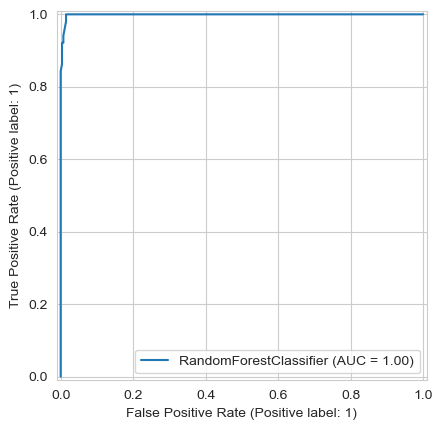

In [48]:
metrics.RocCurveDisplay.from_estimator(model, X_test, y_test)

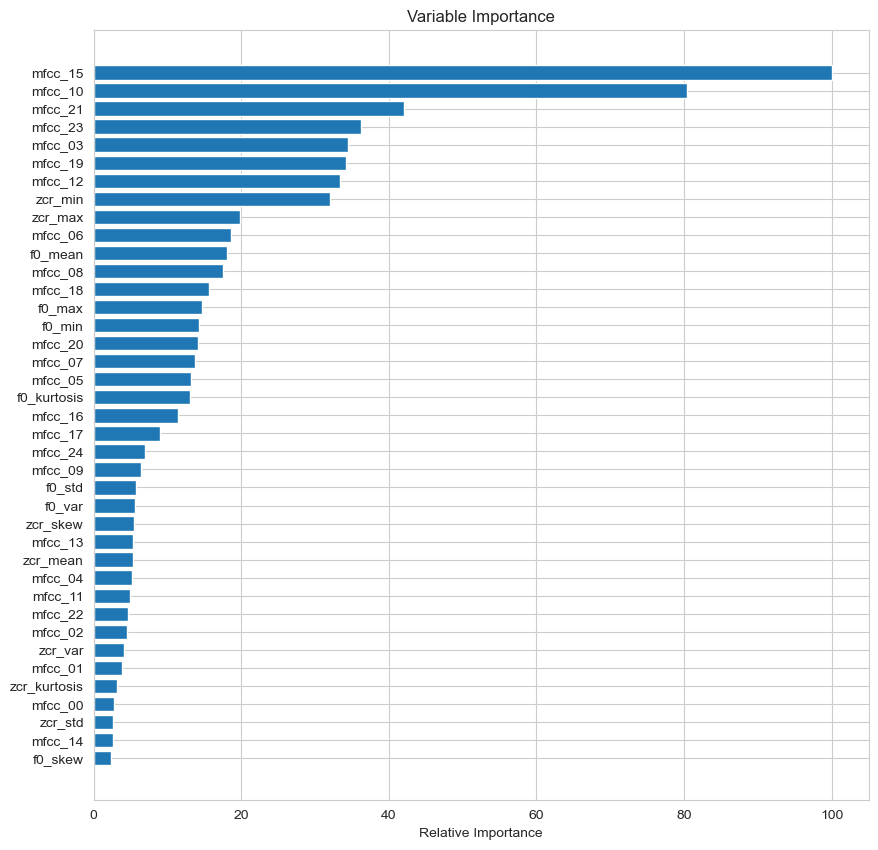

In [49]:
# Plot feature importance
model = rf_clf
feature_importance = model.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 10))
pos = np.arange(sorted_idx.shape[0]) + .8
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_feature_name[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
plt.close()

## Recursive Feature Elimination (RFE)

In [50]:
from sklearn.feature_selection import RFE
rf_clf = RandomForestClassifier(random_state=7)
rf_rfe = RFE(estimator=rf_clf, n_features_to_select= 10, step=1)
rf_rfe.fit(X_train, y_train)
rf_rfe.ranking_

array([ 6, 29, 18, 13,  1, 30,  3, 24, 27, 23,  1, 11,  8,  4, 10,  5, 20,
        1, 25,  1, 19, 26,  1, 12,  9,  1,  1,  7,  1, 15,  1, 16, 28, 17,
       22,  1,  2, 14, 21])

In [51]:
rank = []
feature = []
for x, y in sorted(zip(rf_rfe.ranking_, X_feature_name)):
    rank.append(x)
    feature.append(y)
rfe_feature_rank = pd.DataFrame({'rank':rank, 'feature':feature})
rfe_feature_rank

,rank,feature
0,1,f0_max
1,1,mfcc_03
2,1,mfcc_10
3,1,mfcc_12
4,1,mfcc_15
5,1,mfcc_18
6,1,mfcc_19
7,1,mfcc_21
8,1,mfcc_23
9,1,zcr_min


## Grid Search 

To find best parameters for a given algorithm to fit the data

In [52]:
rf_vanila = RandomForestClassifier(random_state=7)
param_grid = {'n_estimators': [875, 900, 925],
              'criterion': ['entropy'],
              'bootstrap': [True],
              'max_depth': [3,4,5,6,7,8,9],
              'max_features': [5,6,7,8,9,10,11,12,13,14],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [6, 7, 8]}
                                  
rf_select = GridSearchCV(rf_vanila, param_grid=param_grid, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
rf_select.fit(X_train, y_train)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


/opt/anaconda3/envs/voice/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=7), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_features': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [6, 7, 8],
                         'n_estimators': [875, 900, 925]},
             scoring='roc_auc', verbose=1)

In [25]:
rf_select.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 875}

In [26]:
tn,fp,fn,tp  = metrics.confusion_matrix(y_test, rf_select.predict(X_test)).ravel()/(len(y_test))
tn,fp,fn,tp 

(0.8411214953271028, 0.0, 0.028037383177570093, 0.1308411214953271)

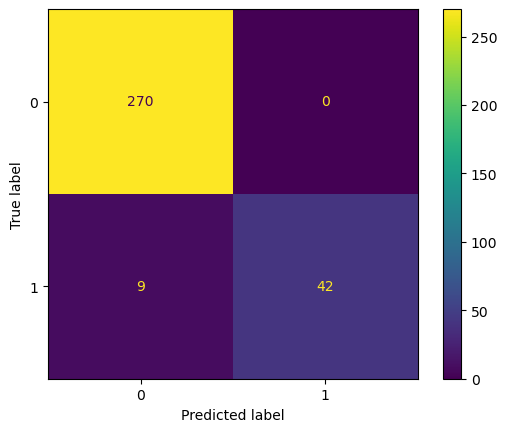

In [27]:
y_pred = rf_select.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

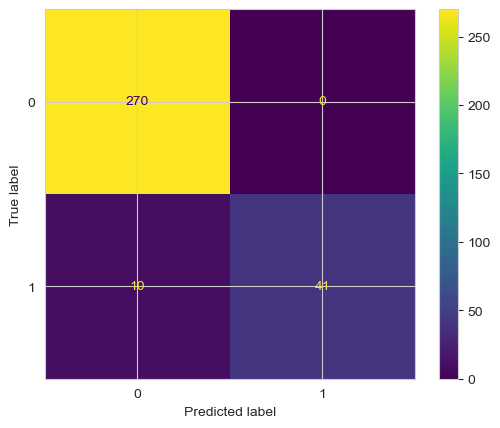

In [35]:
rf_vanila = rf_vanila.fit(X_train, y_train)
y_pred = rf_vanila.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

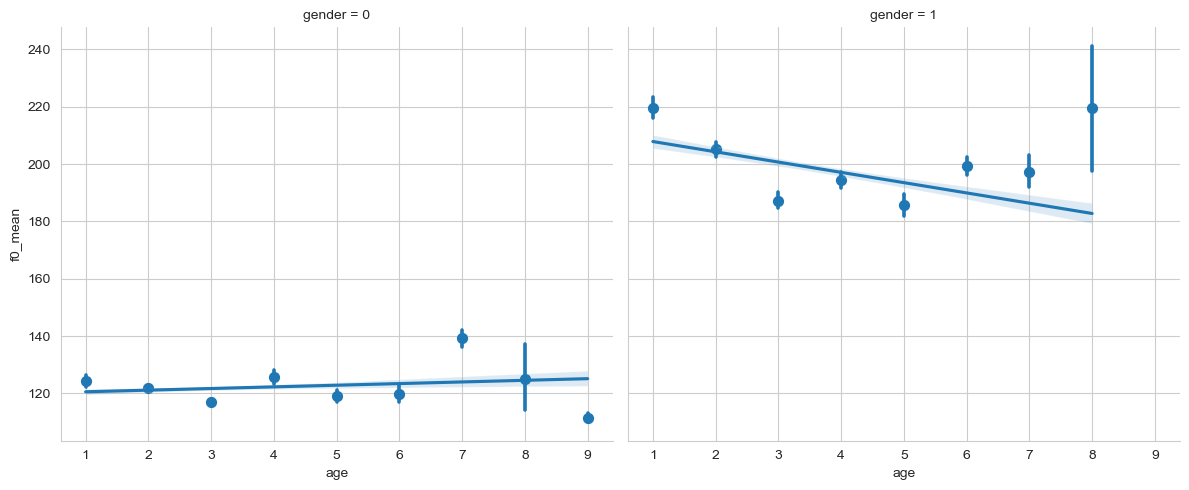

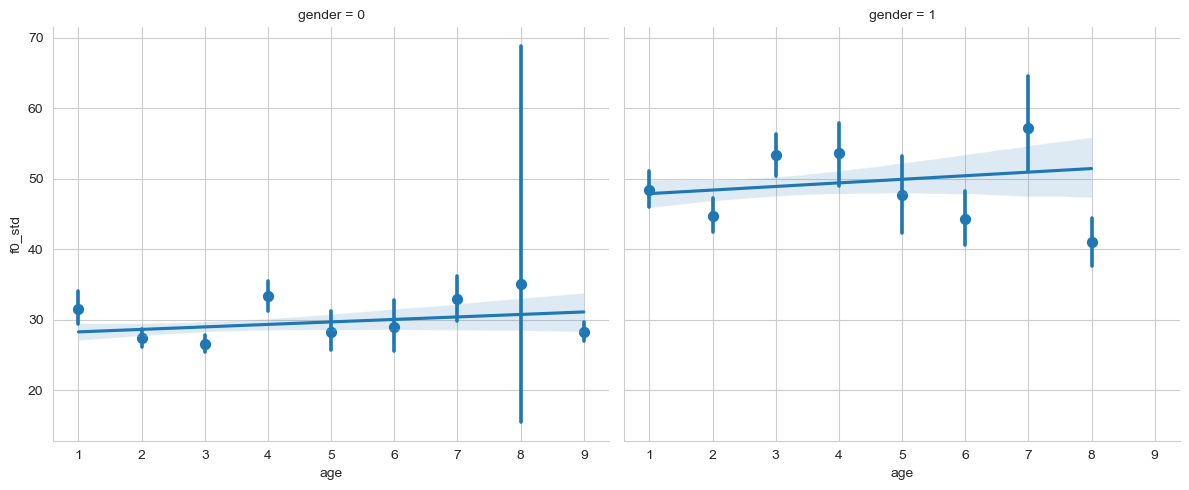

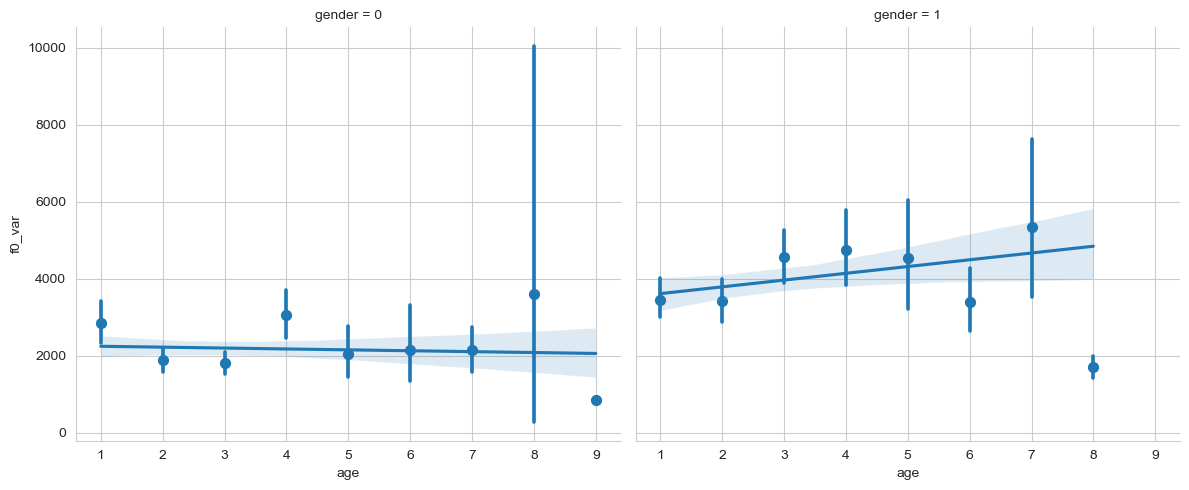

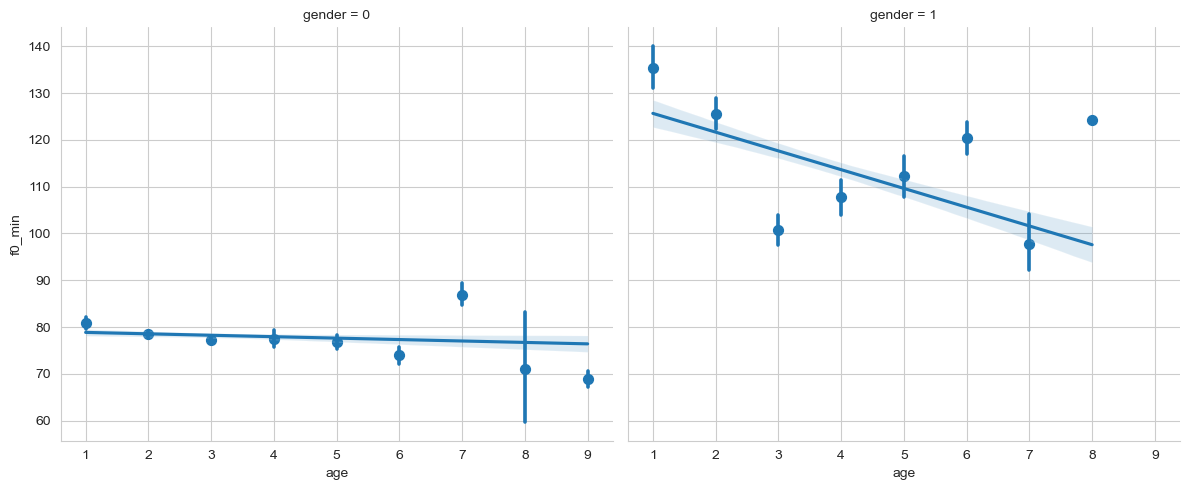

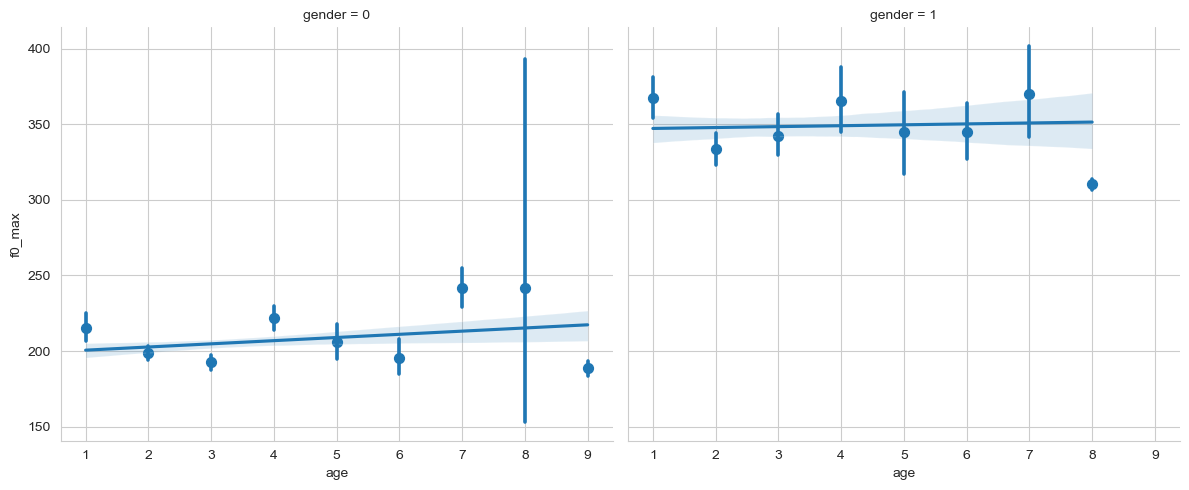

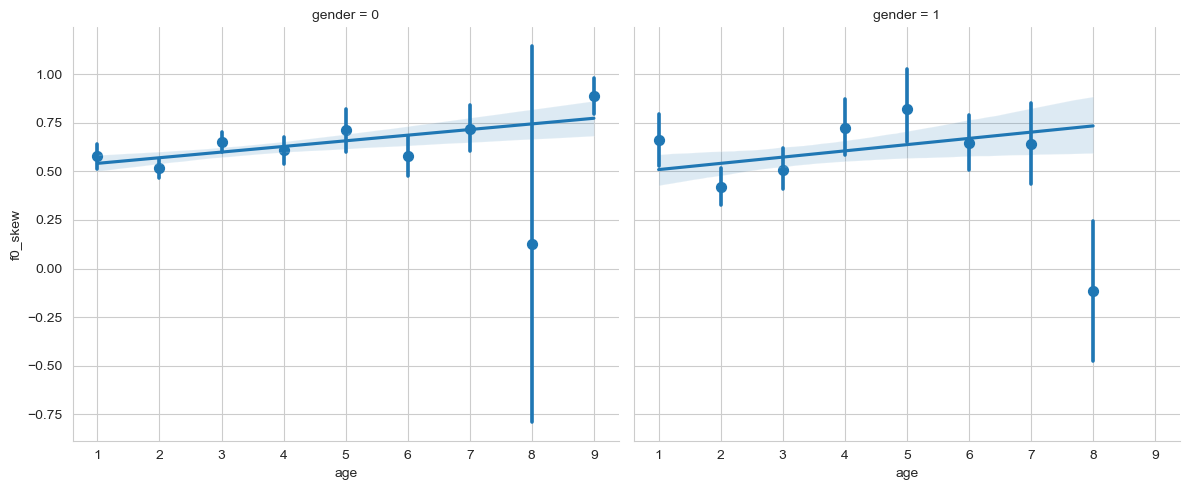

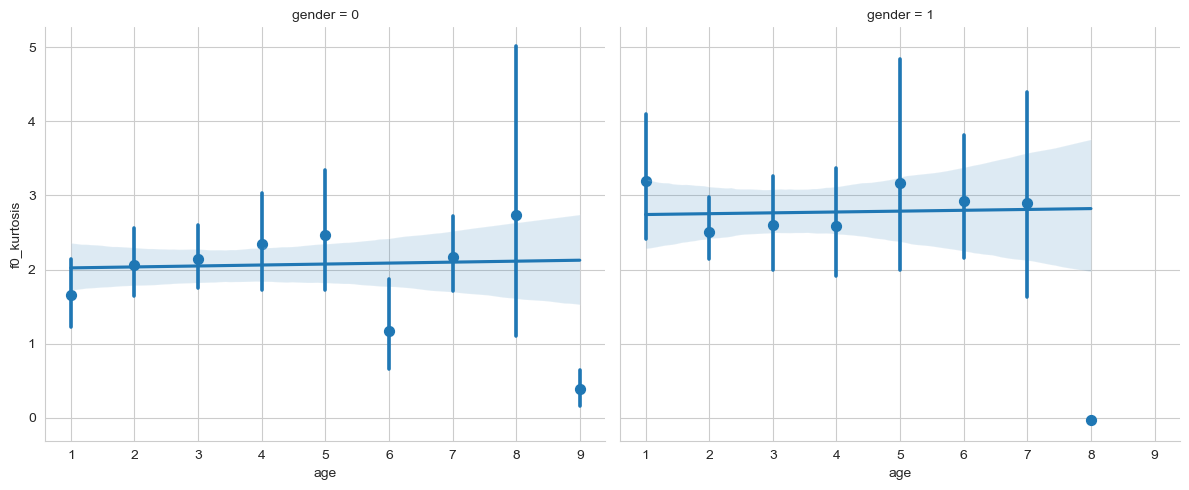

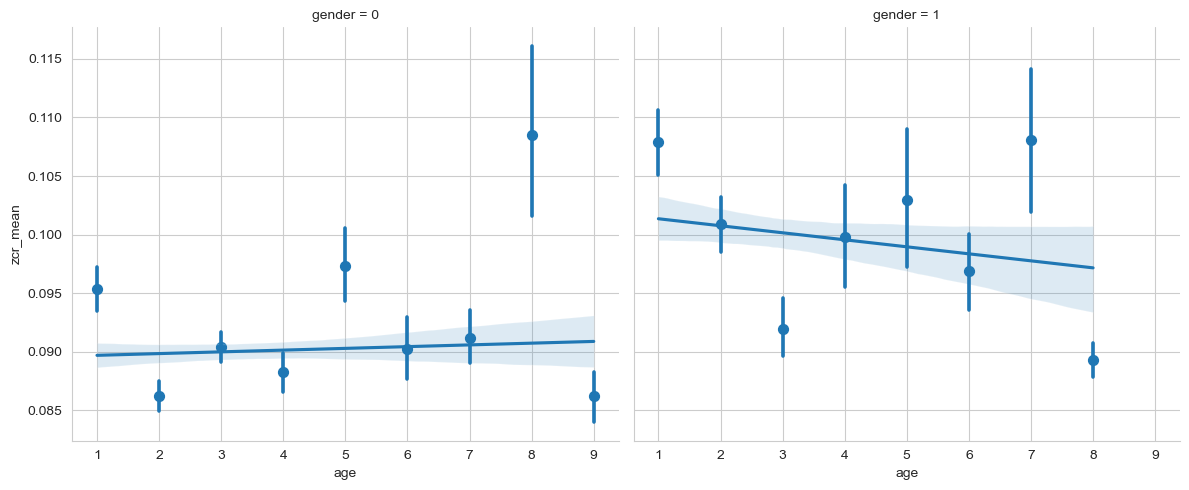

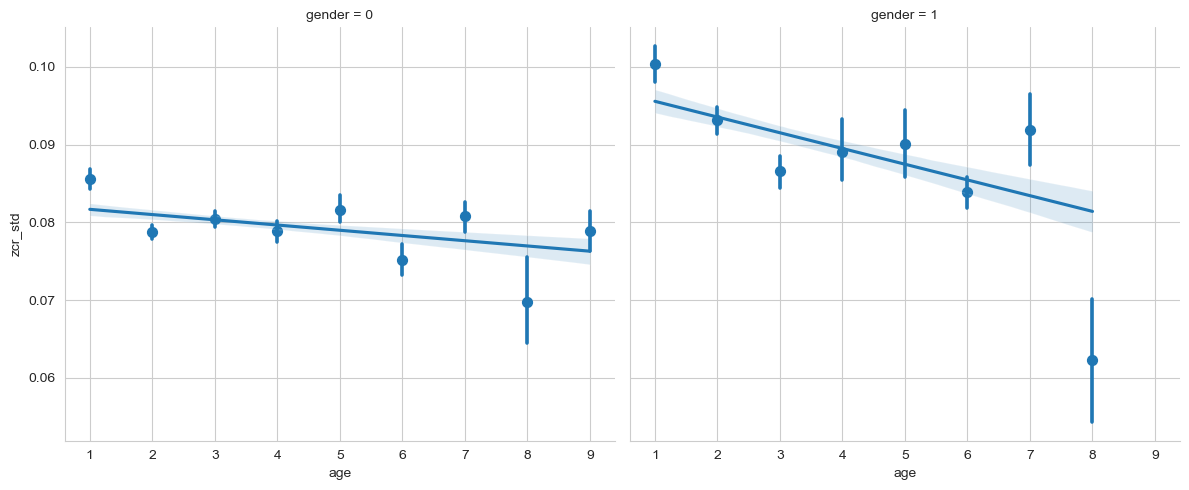

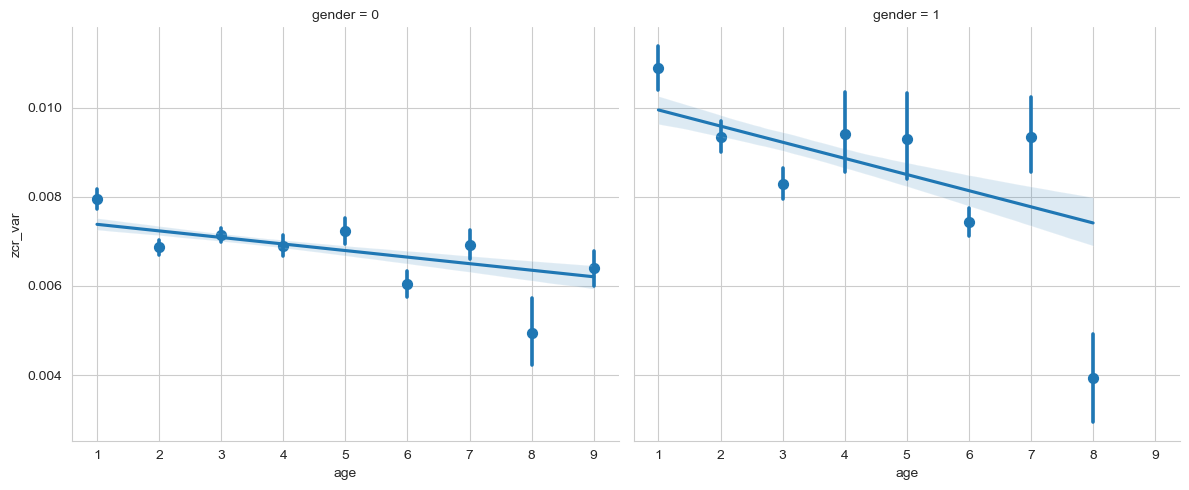

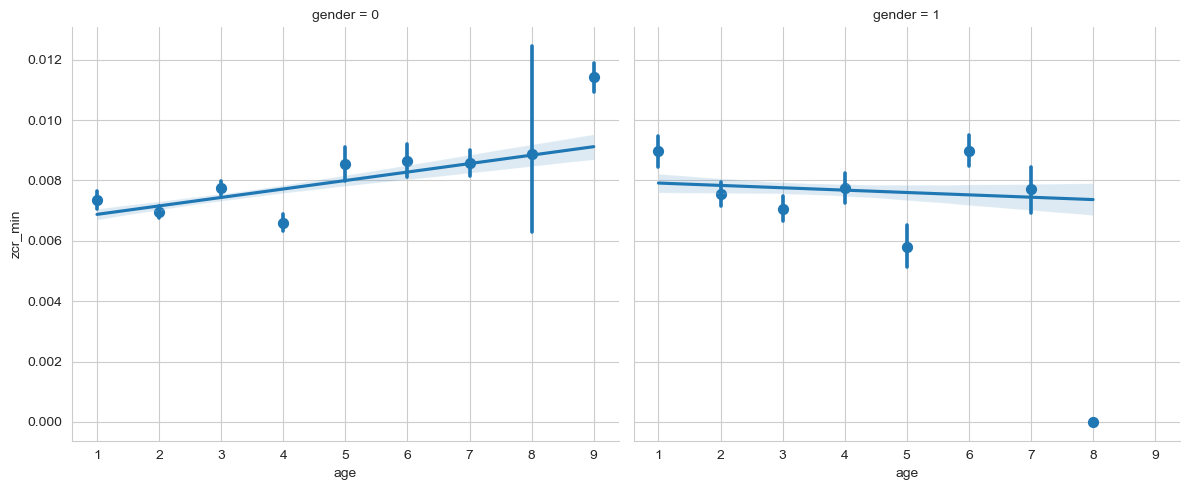

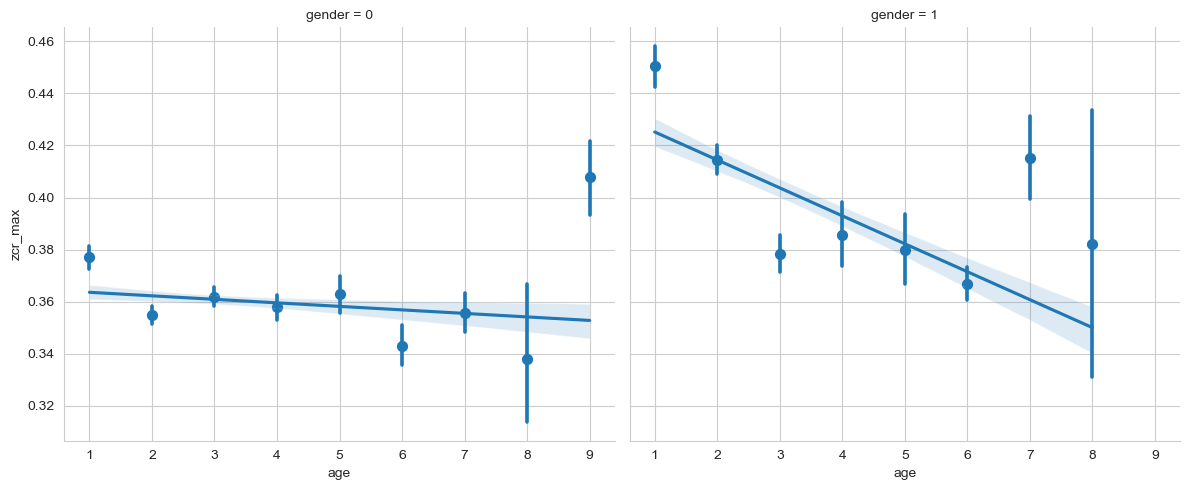

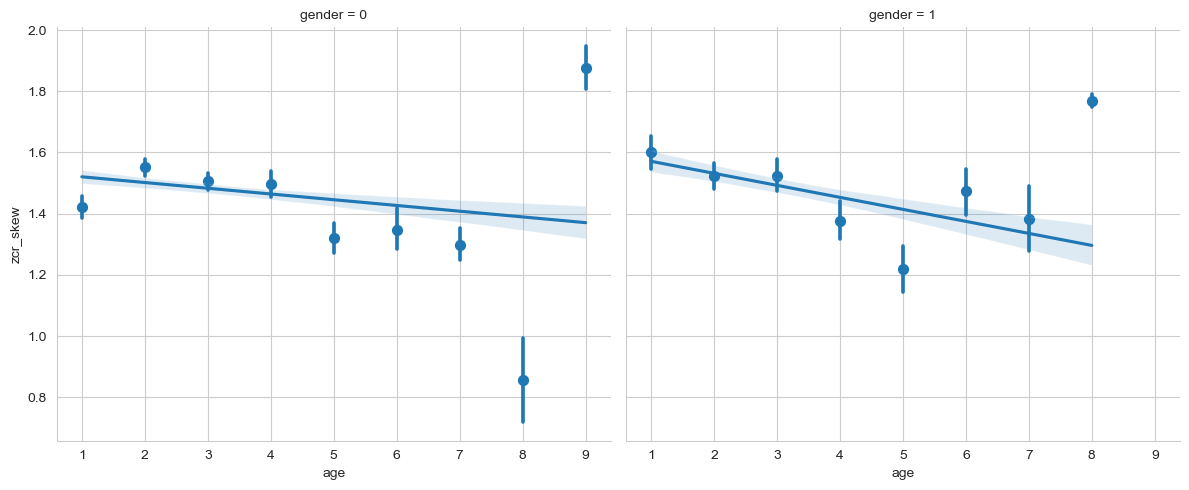

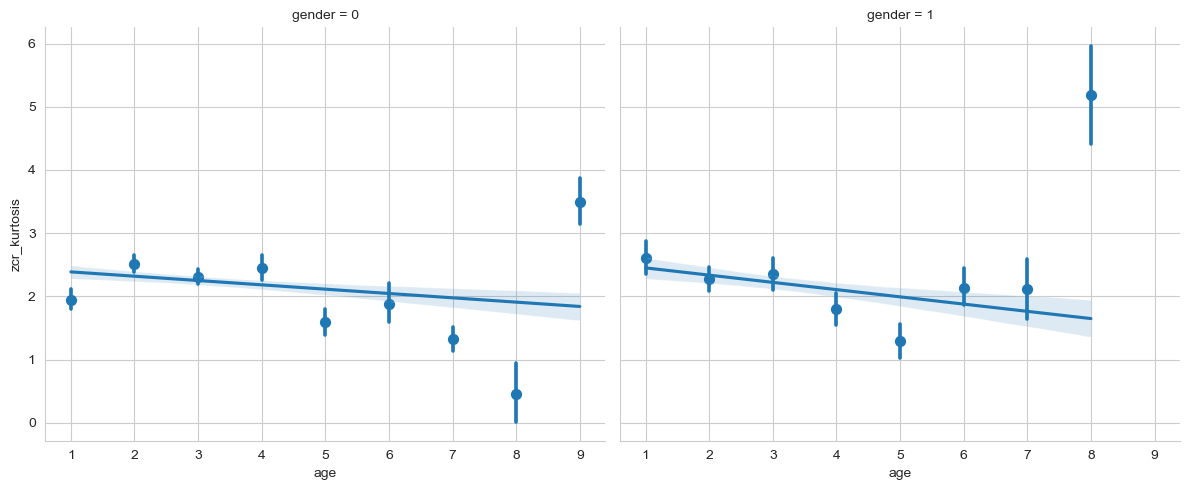

In [28]:
sns.set_style("whitegrid")
feature_col = col_list_f0 + col_list_zcr
for col in feature_col:
    sns.FacetGrid(voice_feature, col="gender", height=5, aspect=1.2).map(sns.regplot, "age", col, x_estimator=np.mean)
    plt.show()
    plt.close() 

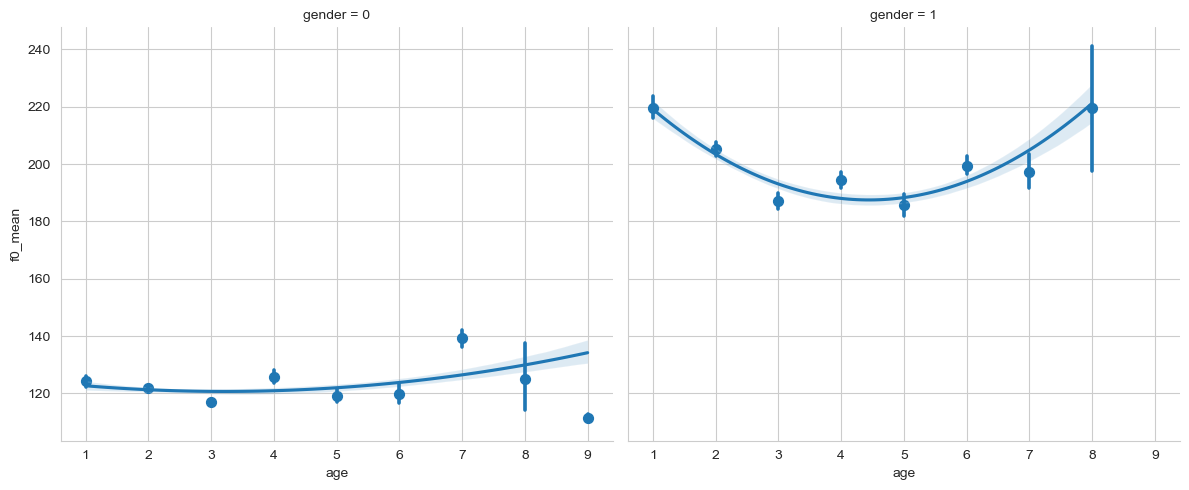

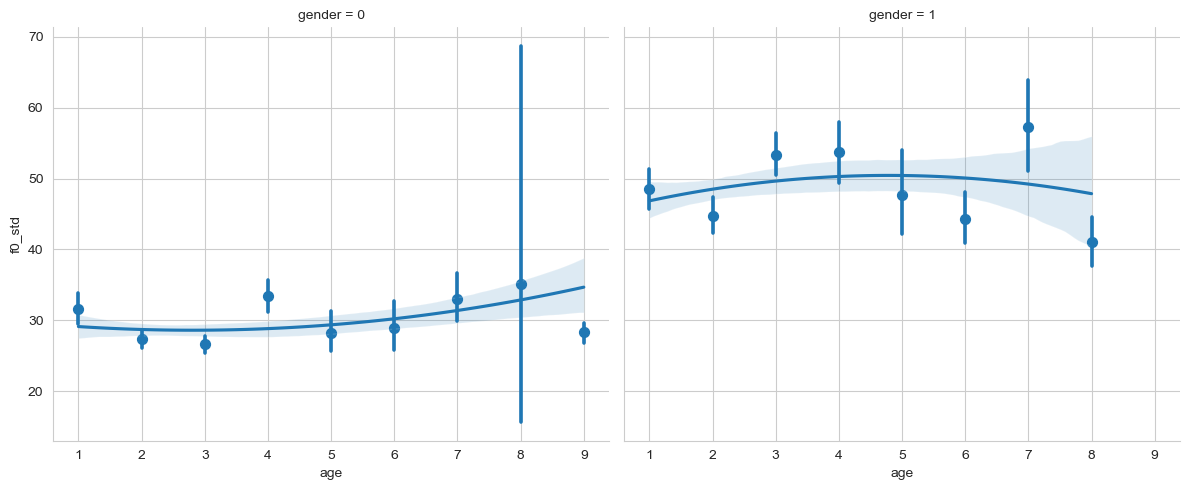

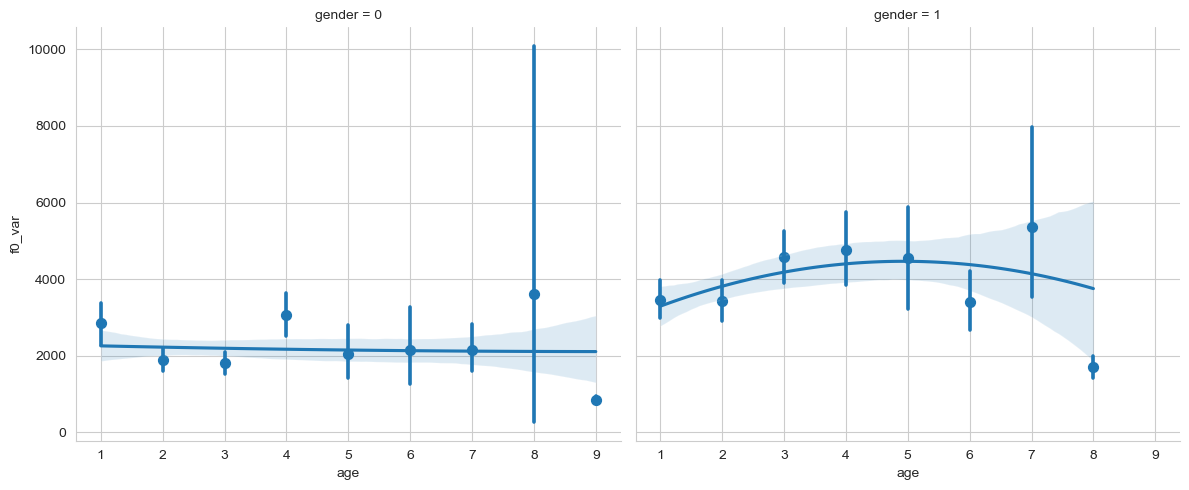

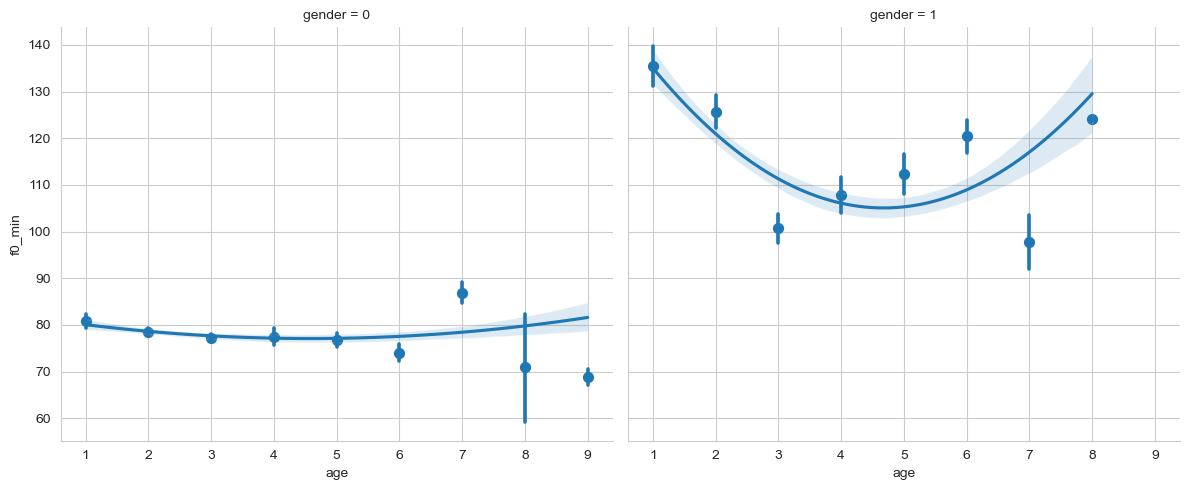

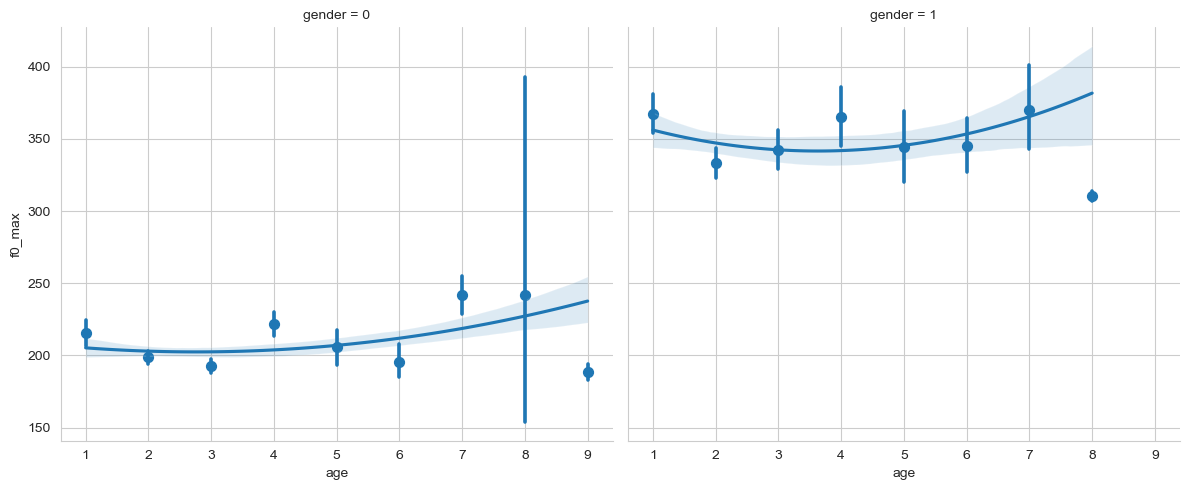

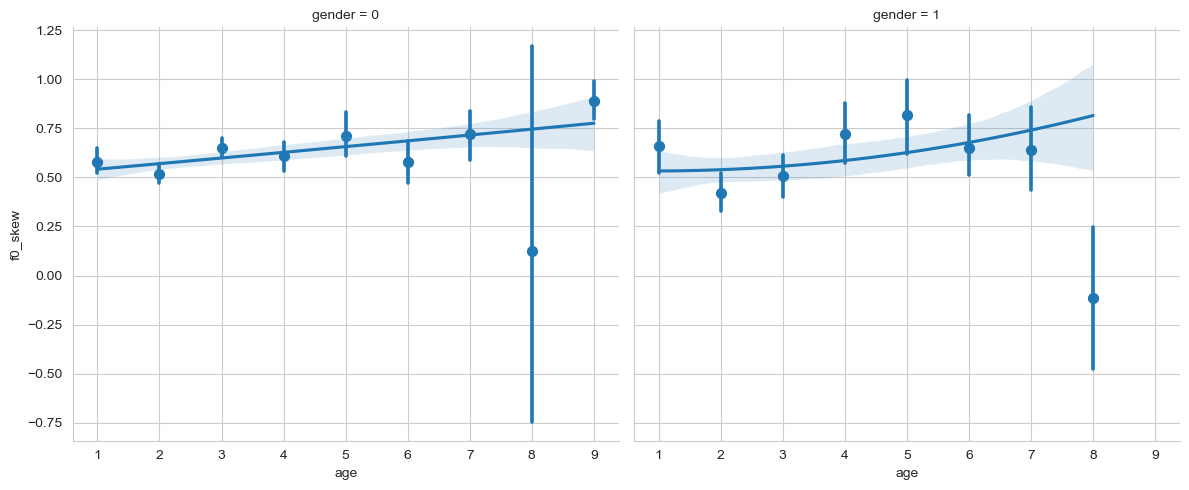

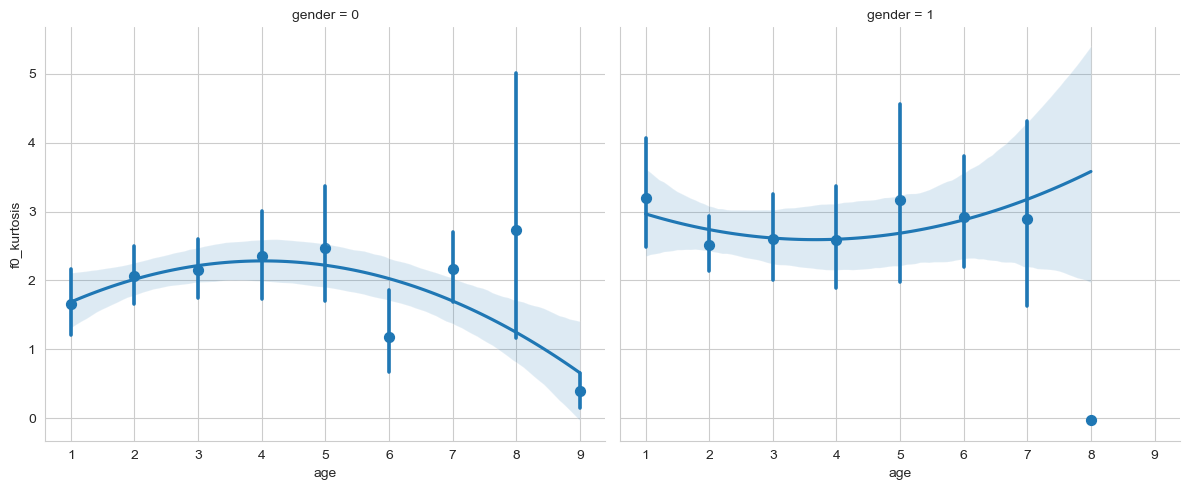

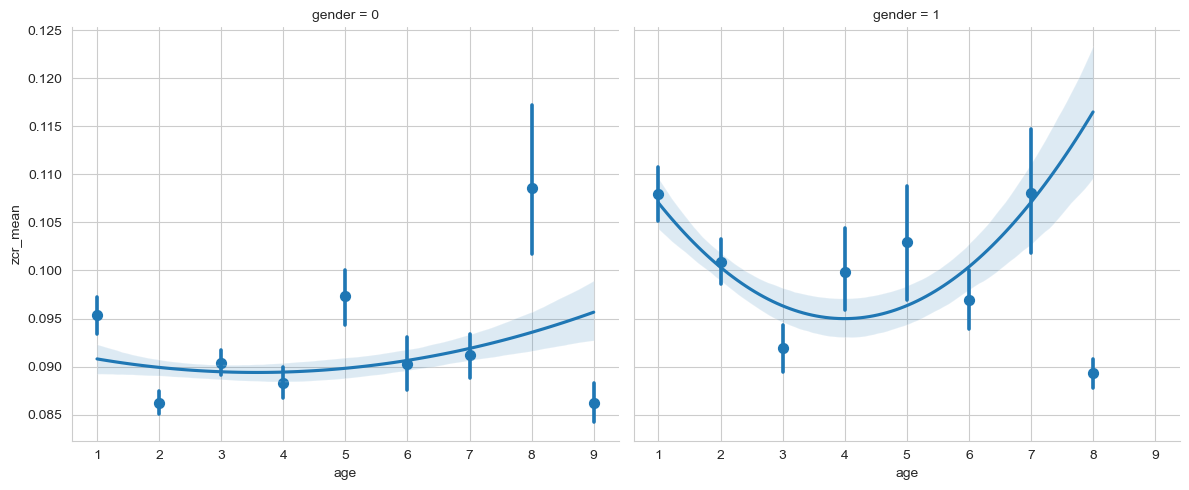

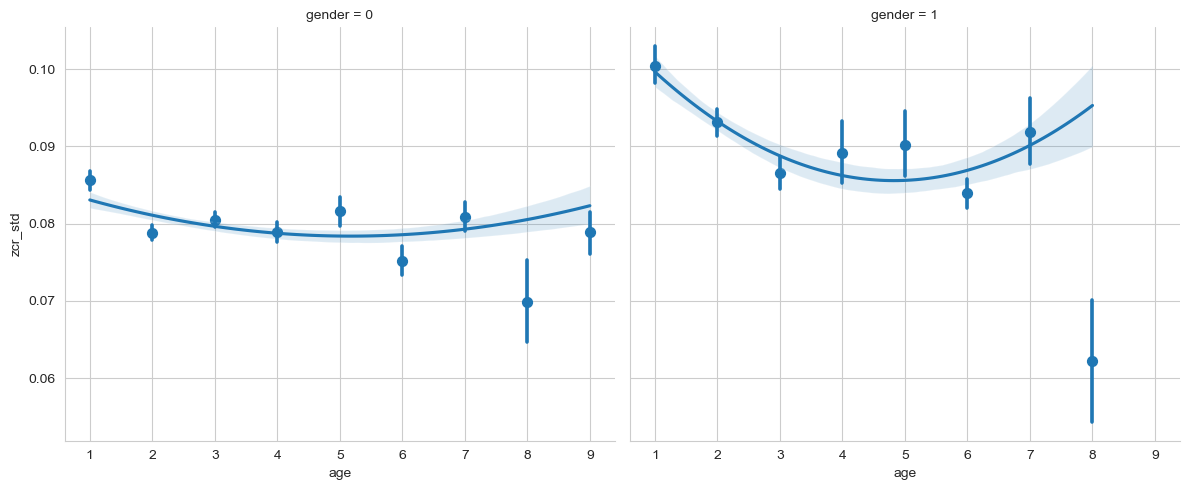

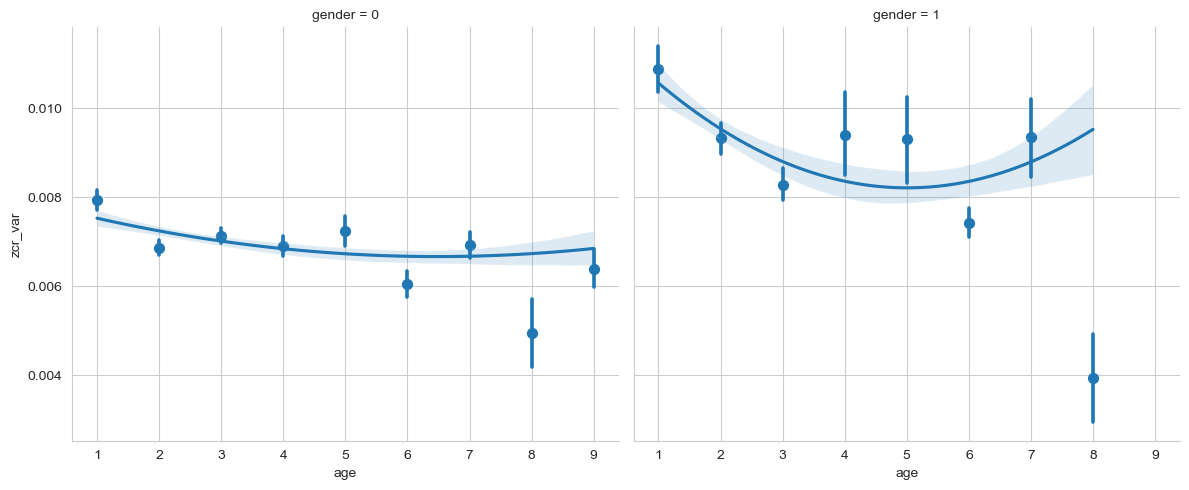

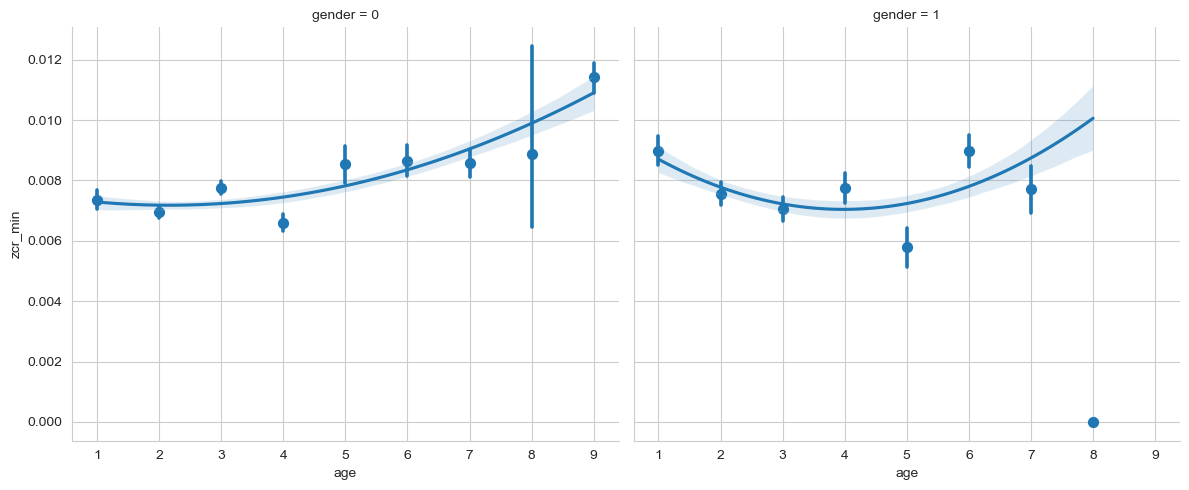

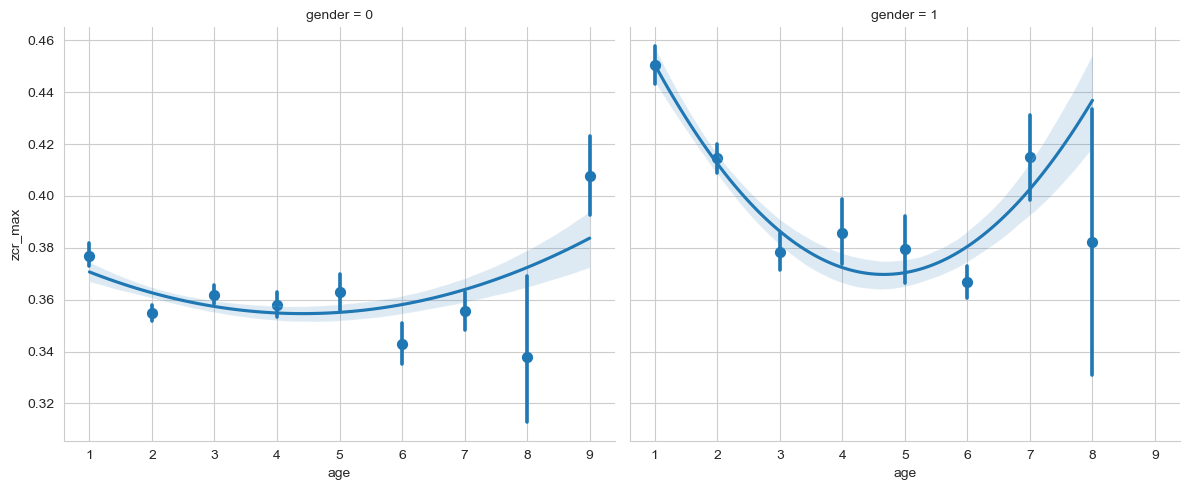

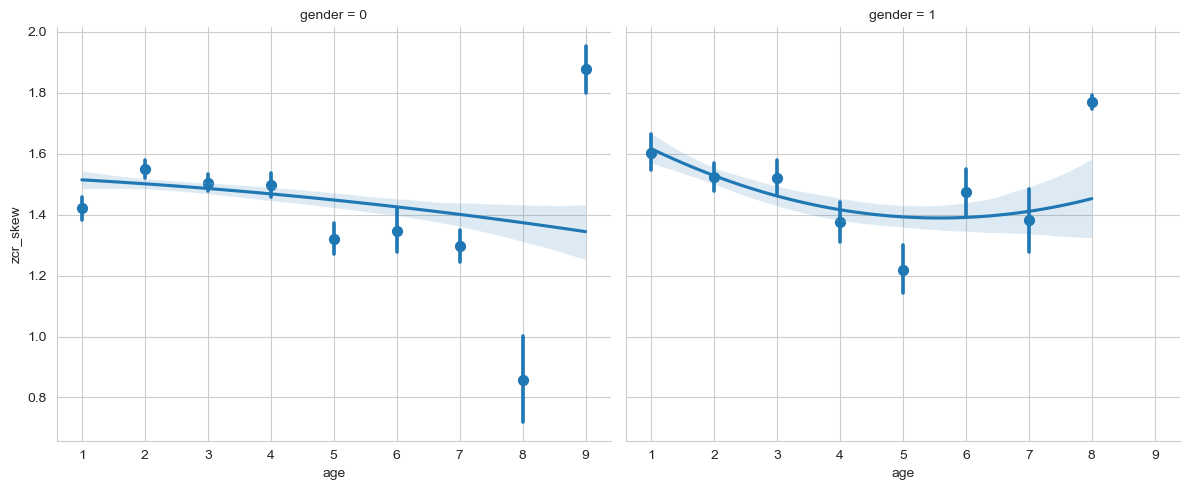

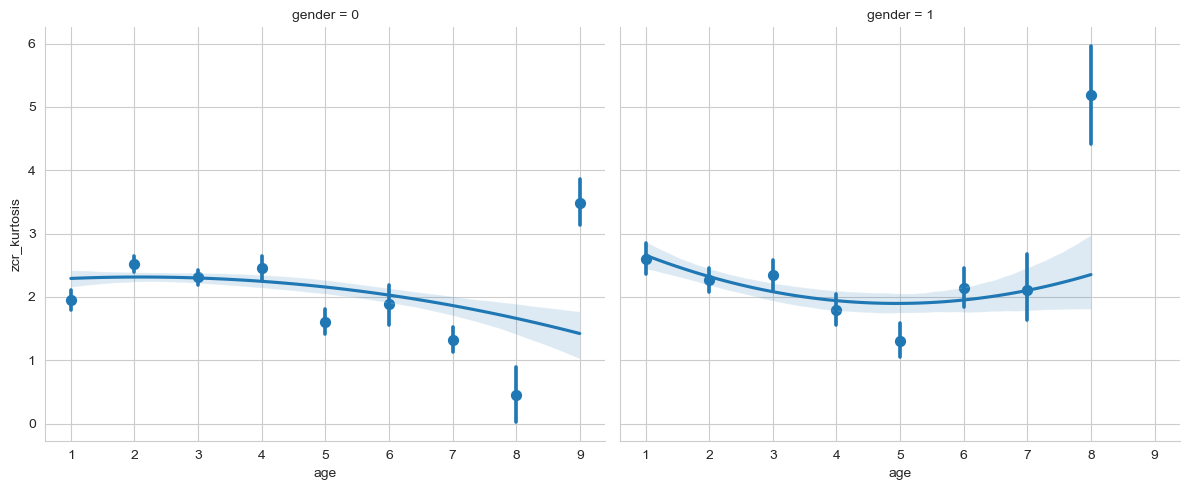

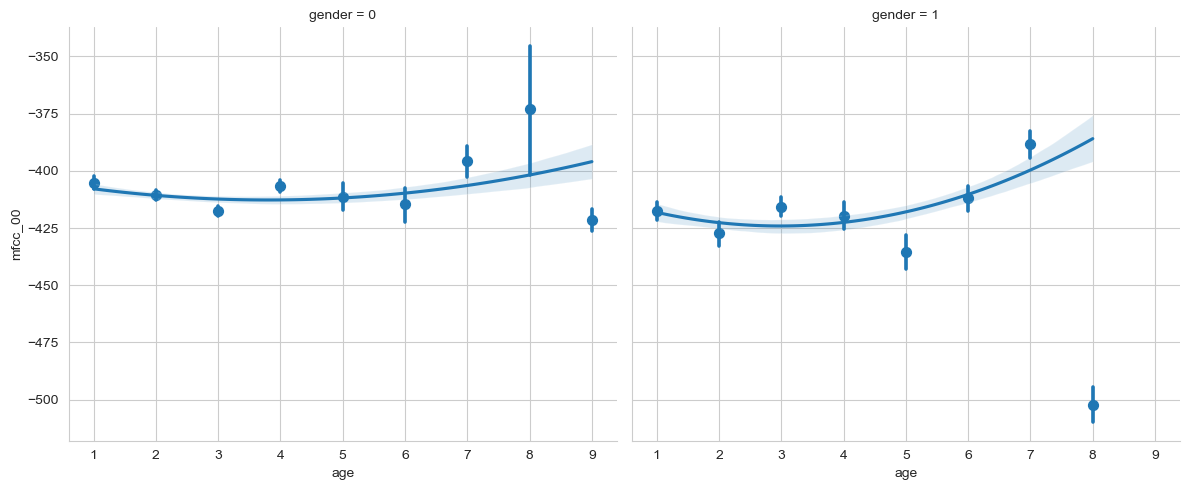

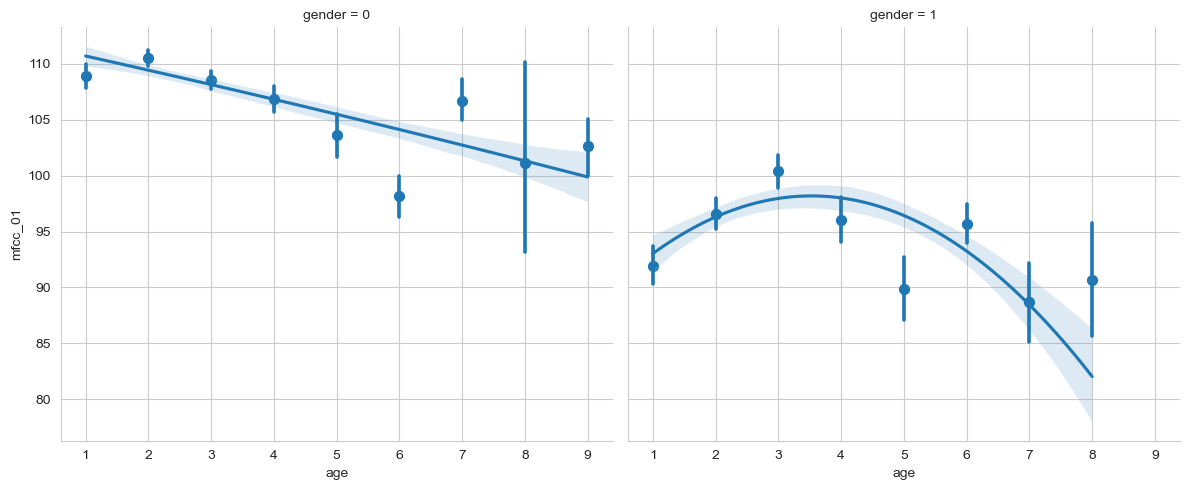

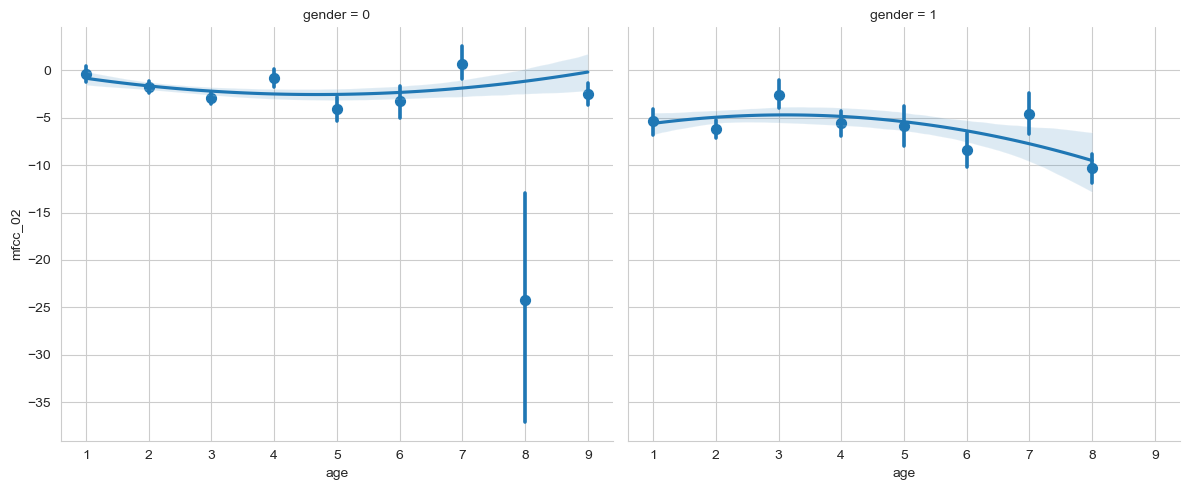

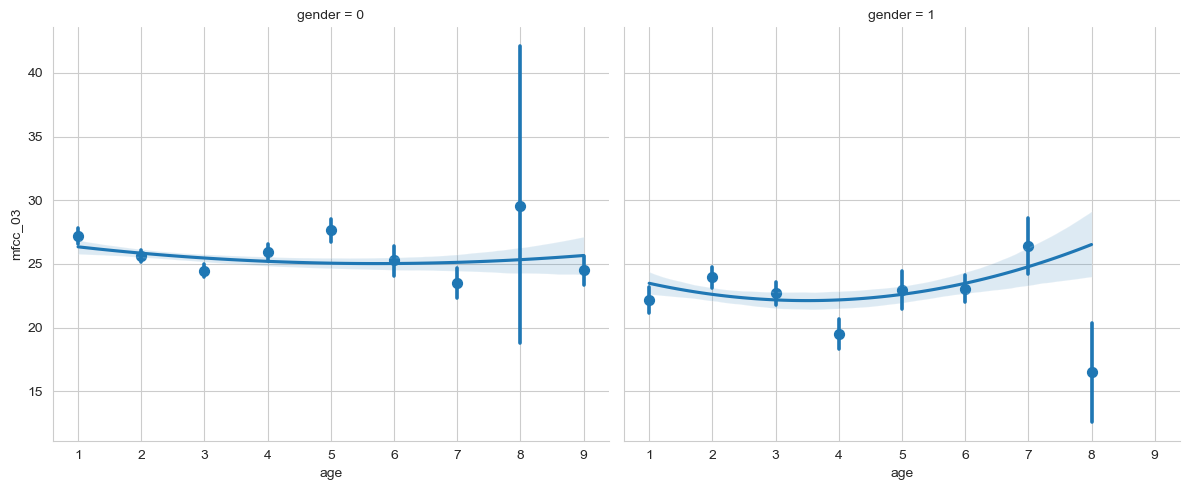

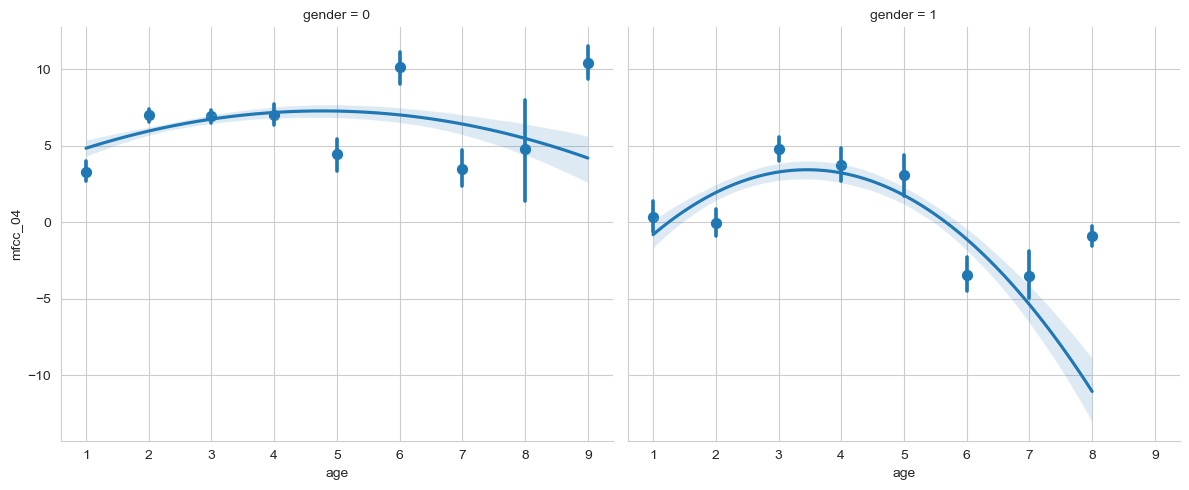

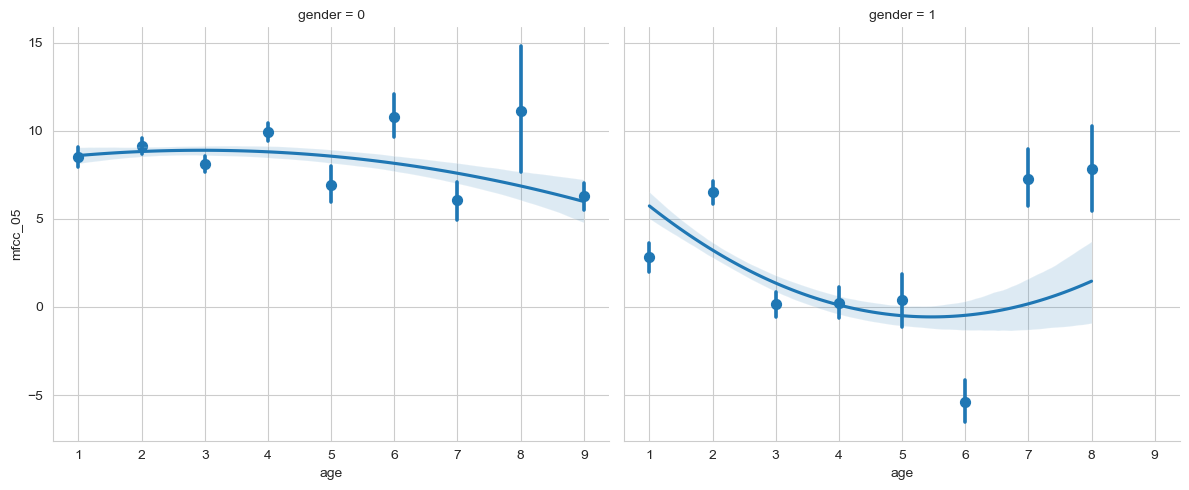

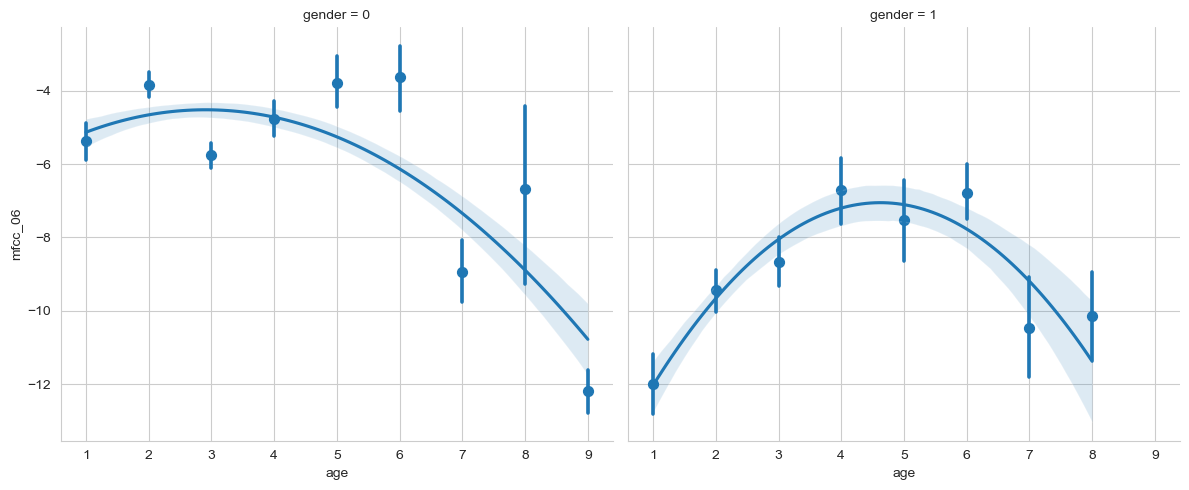

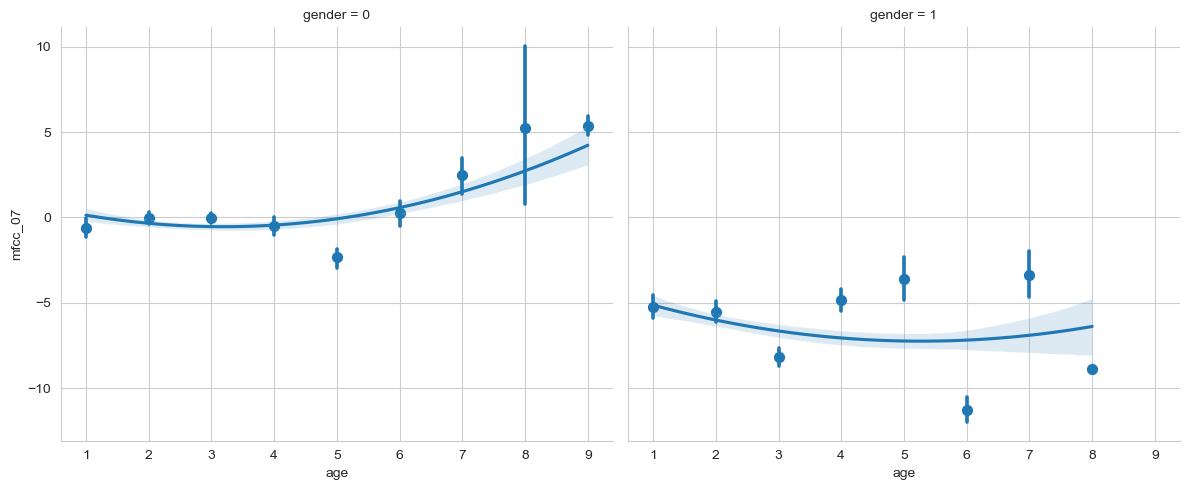

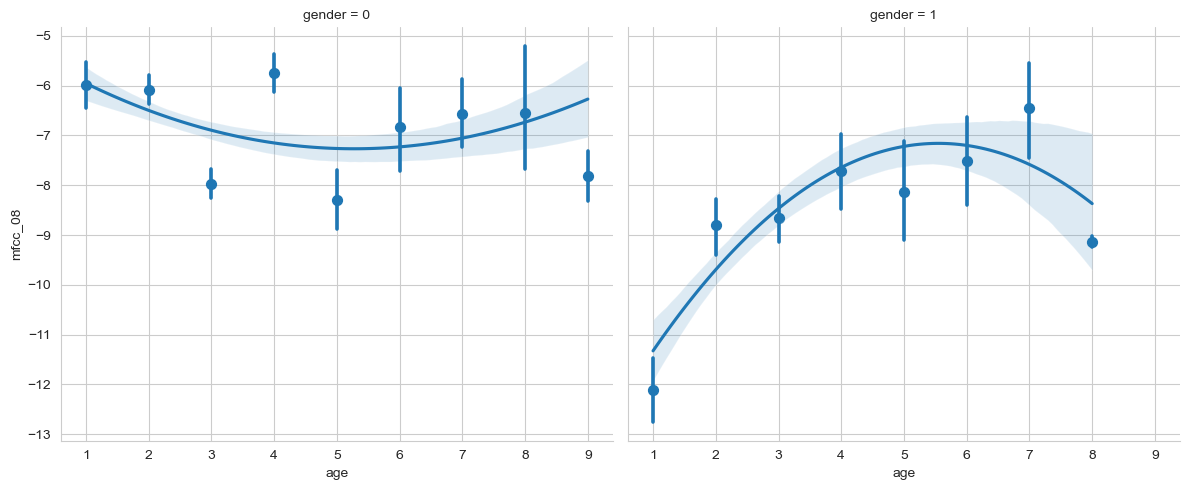

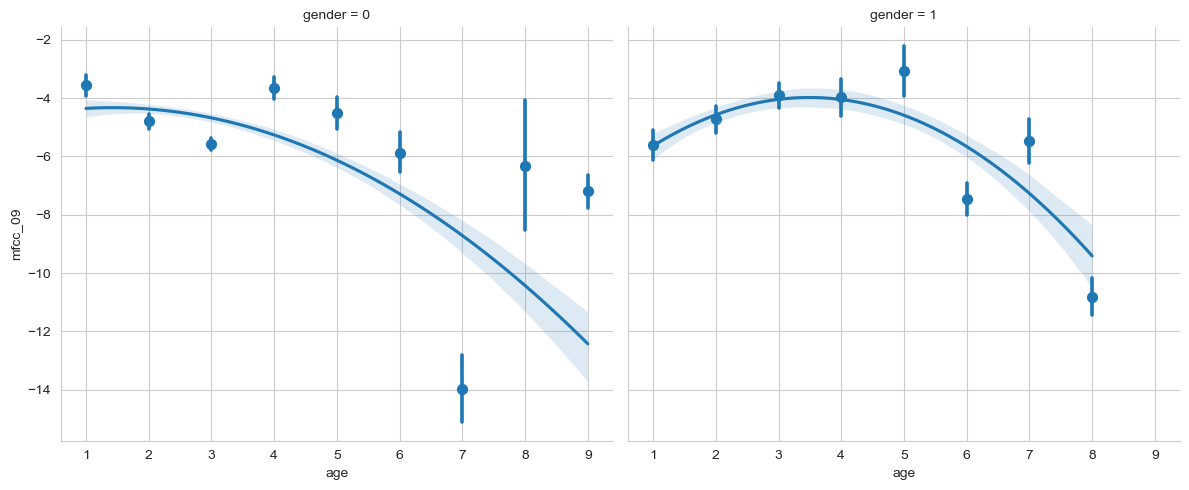

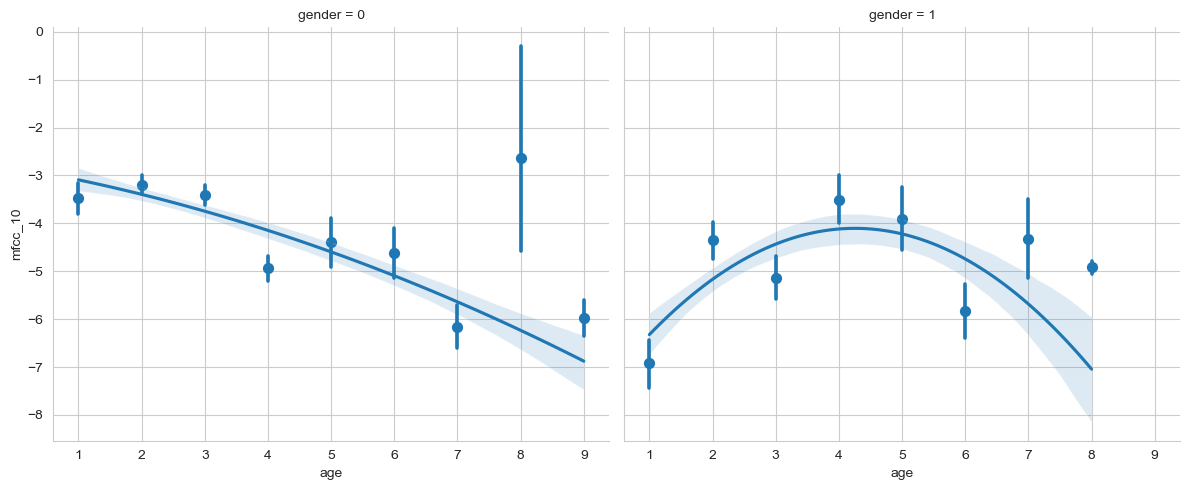

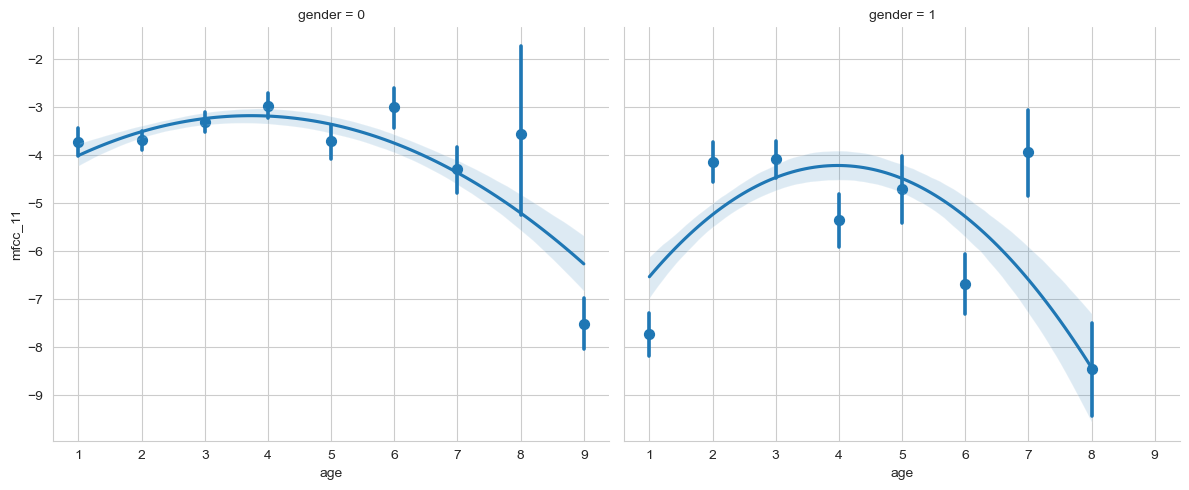

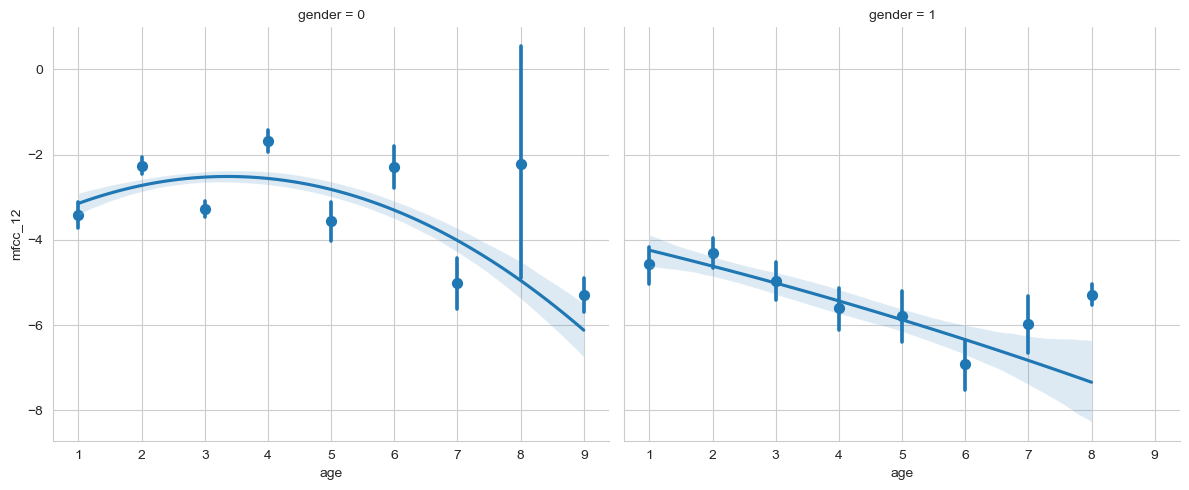

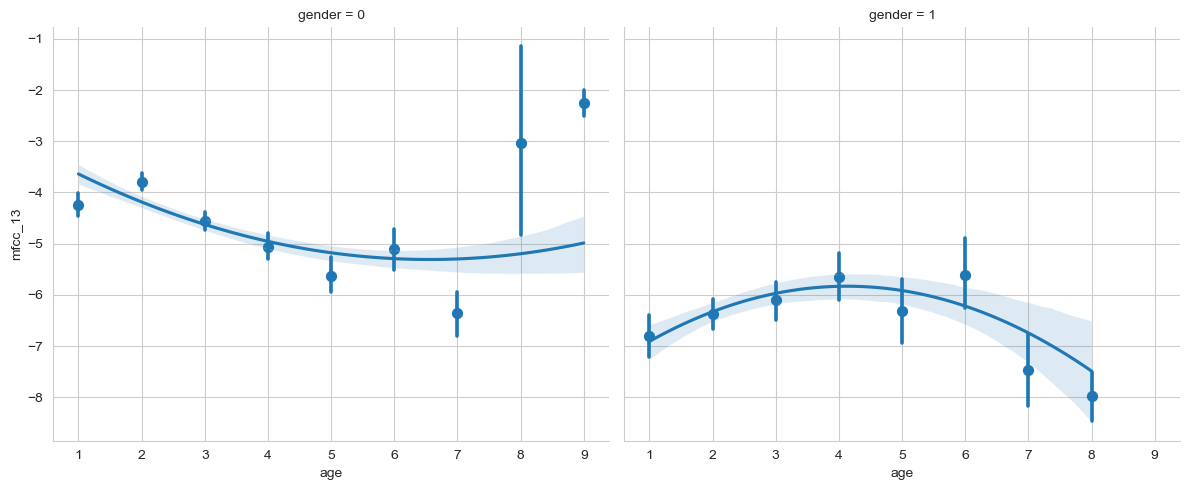

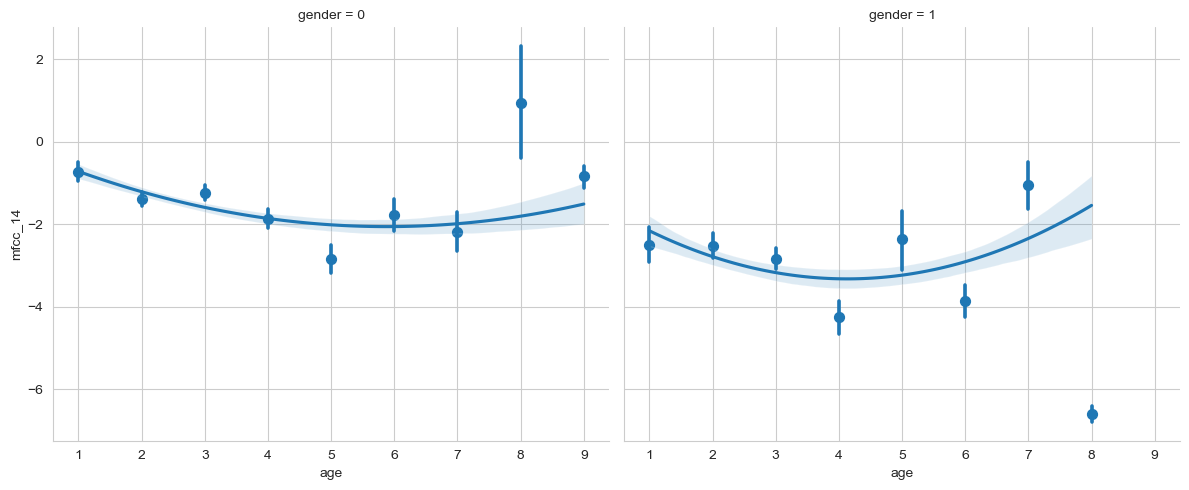

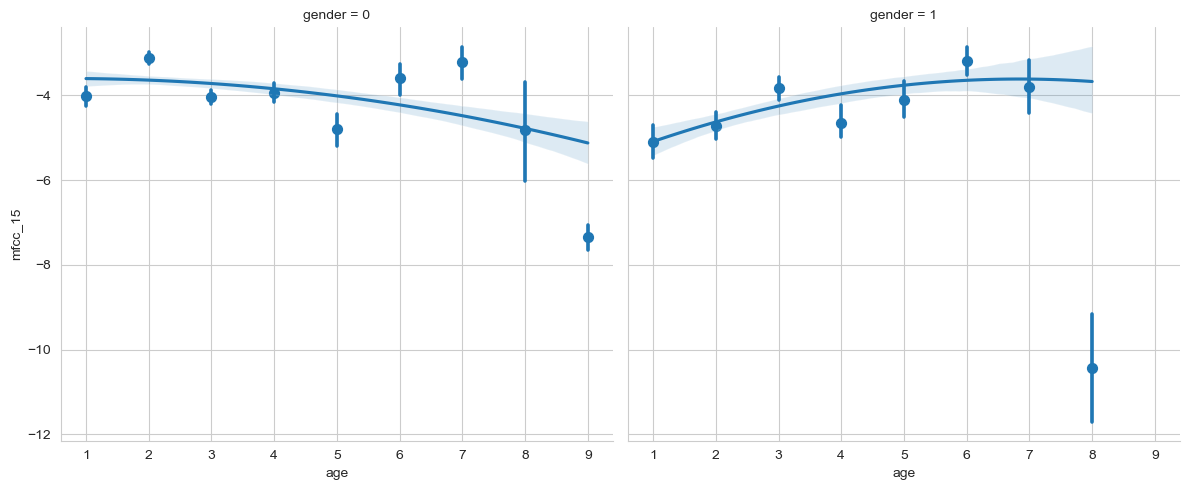

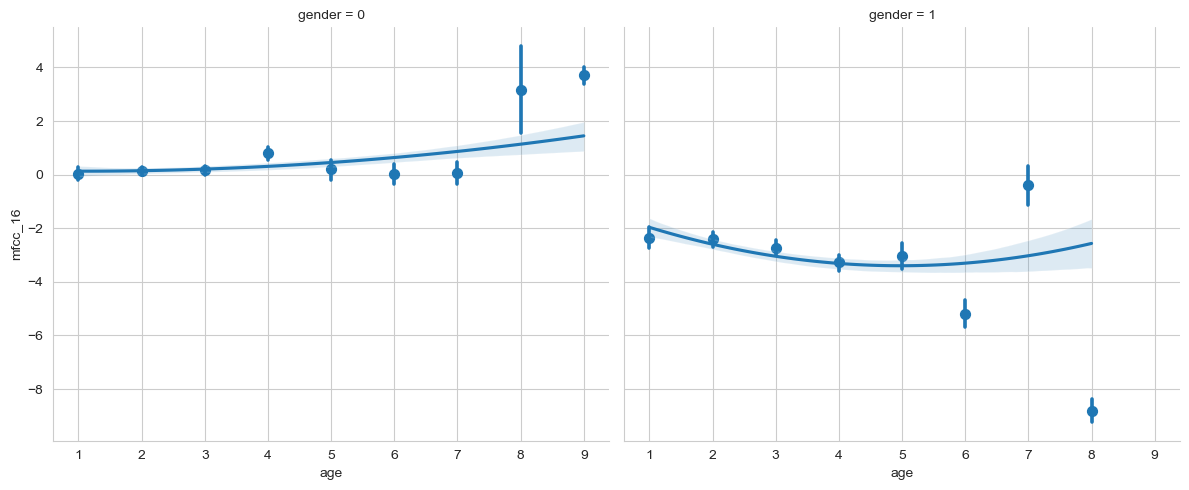

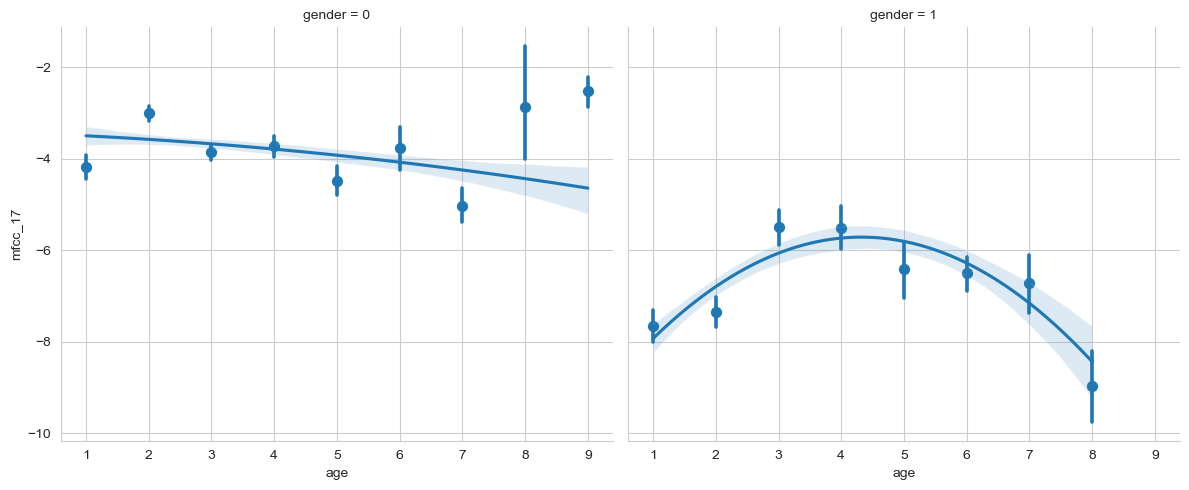

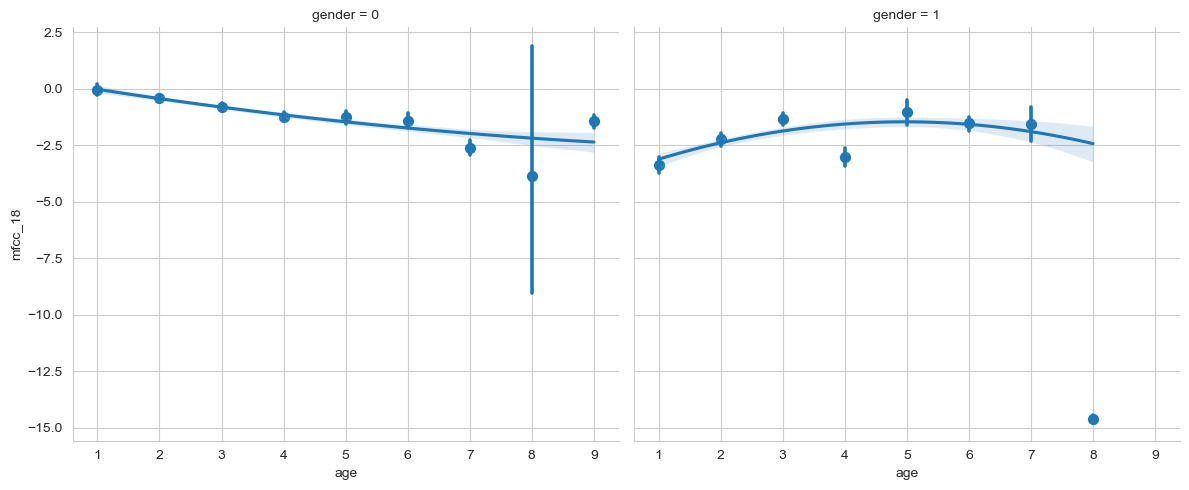

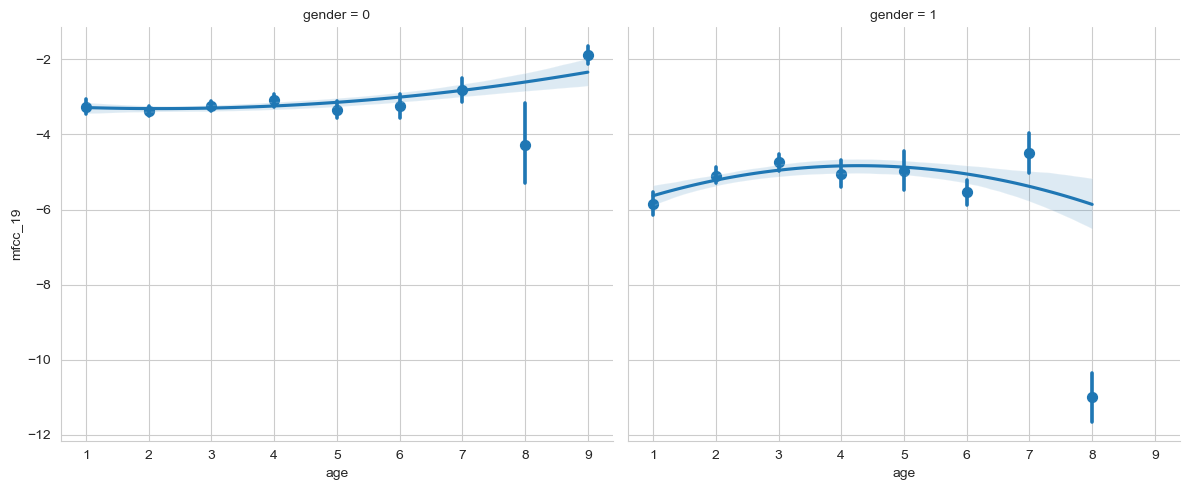

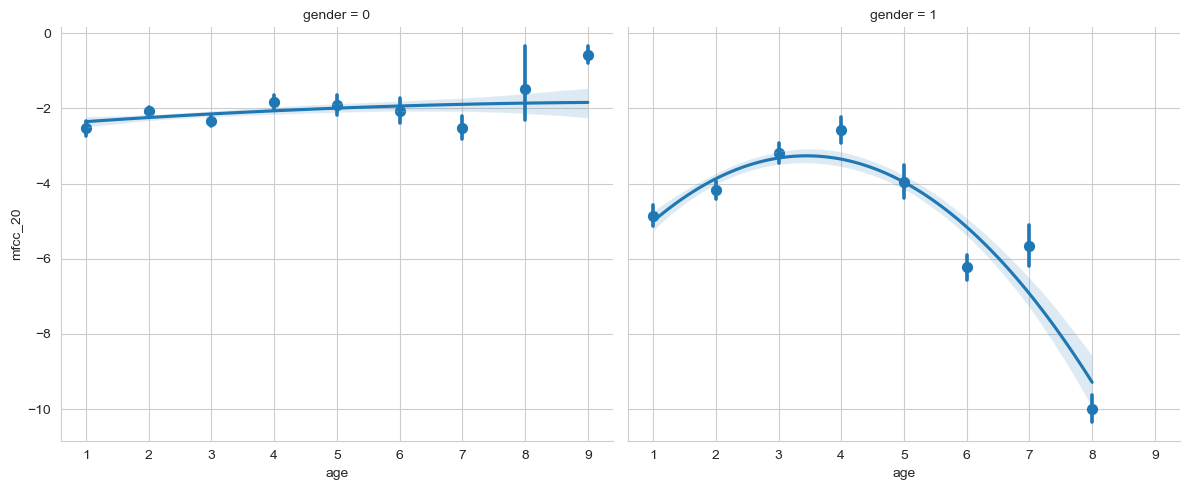

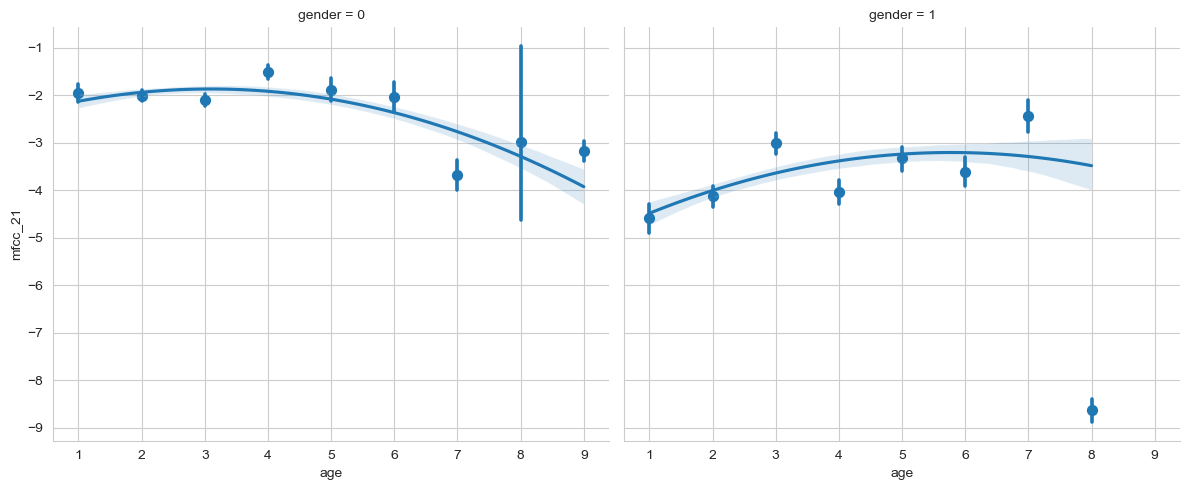

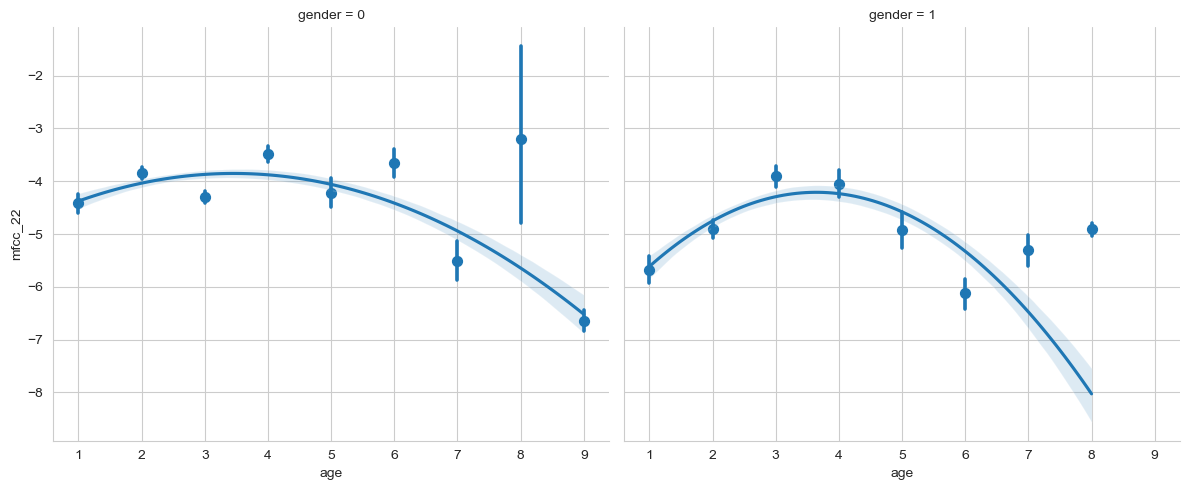

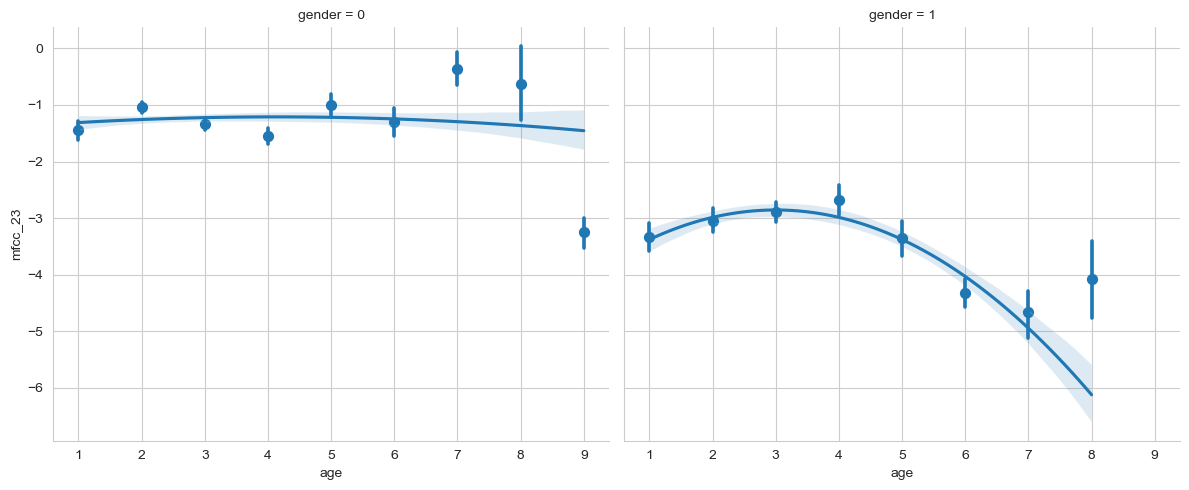

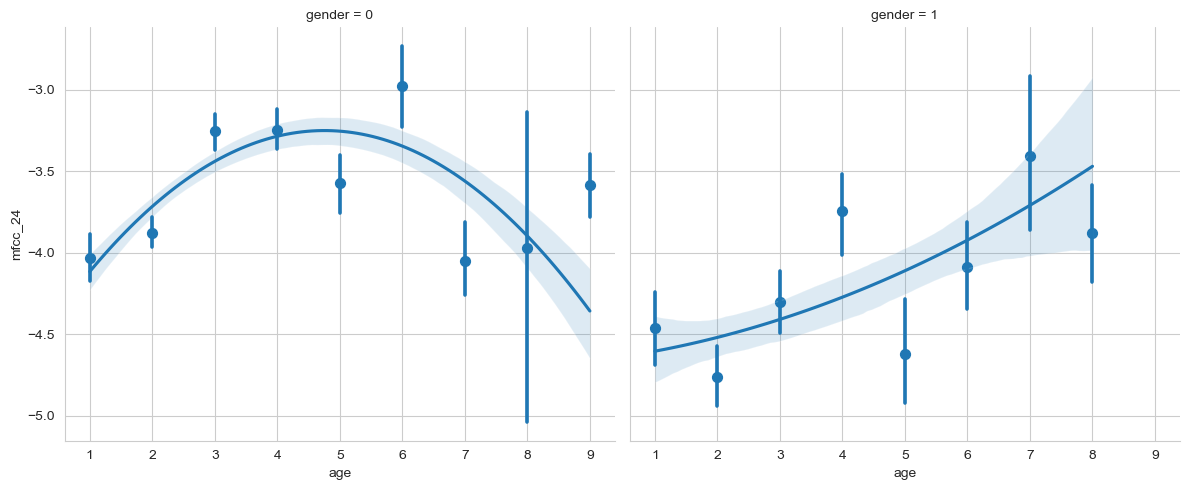

In [29]:
feature_col = col_list_f0 + col_list_zcr + col_list_mfcc
for col in feature_col:
    sns.FacetGrid(voice_feature, col="gender", height=5, aspect=1.2)\
        .map(sns.regplot, "age", col, x_estimator=np.mean, order =2)
    plt.show()
    plt.close() 